# Introdução

Este notebook foi desenvolvido para abordar um problema de alta relevância na indústria de telecomunicações: a elevada taxa de churn, ou seja, a migração de clientes para concorrentes. Como cientista de dados, meu objetivo é auxiliar a empresa a identificar as principais alavancas de negócio que afetam a decisão dos clientes de cancelar seus serviços, e, com isso, direcionar uma campanha de marketing focada em reter clientes de alto risco.

## Objetivos:

1. **Identificar os fatores que mais influenciam a saída dos clientes:** Através de uma análise detalhada dos dados históricos, determinarei as variáveis mais relevantes que impactam a retenção de clientes.
   
2. **Priorizar clientes para a campanha de marketing:** Usando modelos preditivos, recomendarei quais clientes na base `fel_churn_previsão.csv` devem ser abordados em primeiro lugar para maximizar o impacto da campanha de retenção.

3. **Avaliar o impacto econômico:** Calcular a economia em número de campanhas individuais ao focar nos clientes identificados como de alta propensão à saída, comparando com uma abordagem de marketing mais ampla.

4. **Validar a performance do modelo:** Avaliar a precisão das previsões e justificar a escolha dos modelos utilizados.

5. **Extração de insights adicionais:** Além das perguntas principais, explorarei o conjunto de dados em busca de insights adicionais que possam ser valiosos para a área de negócio.

## Estrutura do Notebook:

O notebook está dividido em 8 seções, cada uma representando uma fase do processo de data science:

1. **Descrição dos Dados:** Análise inicial para entender a distribuição dos dados, checar valores nulos, identificar padrões e detectar outliers.
   
2. **Mapa de Hipóteses:** Criação do mapa mental de hipóteses.

3. **Análise Exploratória de Dados:** Análise estatística visual aprofundada visando a identificação de insights e validação das hipóteses.

4. **Preprocessamento dos Dados:** Transformações, normalizações e processamentos iniciais dos dados.

5. **Modelagem de Machine Learning:** Treinamento de diferentes modelos de machine learning para classificação.

6. **Otimização de Hiperparâmetros:** Otimização de hiperâmetros do modelo escolhido.

7. **Tradução e Interpretação de Erros:** Análise de performance do modelo e suas principais métricas.

8. **Análise de Negócio:** Insights, respostas e próximos passos com relação ao problema de negócio proposto

## Storytelling:

Além das análises técnicas, este notebook também inclui um storytelling focado na apresentação dos resultados para a área de negócios. A linguagem utilizada nesta parte será mais acessível, destacando as conclusões de maneira clara e objetiva.

# 0.0. IMPORTS

In [137]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import xgboost as xgb
import pickle
import plotly.express as px
import plotly.graph_objects as go

import optuna
from optuna.samplers import TPESampler

from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder, TargetEncoder, WOEEncoder, BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, confusion_matrix)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 0.1. Helper Functions

In [138]:
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def set_annotate(fig, h=False, porcentages=False):
    """
    Adiciona anotações aos retângulos em um gráfico de barras.

    Args:
        fig: matplotlib.figure.Figure 
            Objeto figura matplotlib.
        h: bool
            Se verdadeiro, a anotação será horizontal; caso contrário, será vertical.
        porcentage: bool: 
            Se verdadeiro, os valores serão exibidos como porcentagens; caso contrário, como valores brutos.
    """
    
    for ax in fig.get_axes():
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            if width > 0 and height > 0:
                if h:
                    reference = width 
                    xy = (p.get_x() + width, p.get_y() + height / 2)
                    ha="left"
                    va="center"
                else:
                    reference =  height
                    xy = (p.get_x() + width / 2, p.get_y() + height)
                    ha="center"
                    va="bottom"
                if reference < 0.01:
                    text = "{:.2e}".format(reference)
                else:
                    text = "{:.2f}%".format(reference * 100) if porcentages else "{:.2f}".format(reference)
                
                ax.annotate(text, xy=xy, ha=ha, va=va, fontsize=12, color="black", xytext=(5, 0),
                            textcoords="offset points")

def cross_val(X, y, k, preprocessor, models, return_df=False):
    """
    Avalia o desempenho de uma lista de modelos com a validação cruzada K-Fold 

    X: pd.DataFrame
            Conjunto de dados de entrada (features).
    y: pd.Series
        Labels correspondentes aos dados de entrada.
    k: int 
        Número de folds na validação cruzada.
    preprocessor: Pipeline
        Pipeline de pré-processamento aplicado aos dados antes do treinamento.
    models: list
        Lista de modelos a serem avaliados.
    return_df: bool
        Se True, retorna um DataFrame com as avaliações dos modelos; caso contrário, retorna um dicionário.
    """
    
    modelos_scores = {}

    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    for model in models:
        accuracy, precision, recall, f1, roc_auc, logloss = [], [], [], [], [], []

        for k, (train_index, test_index) in enumerate(folds.split(X, y)):
            X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
            X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        

            pipe = Pipeline(steps=[
                ("preprocessor", preprocessor),   
                ("classifier", model)
            ])
            
            pipe.fit(X_train_interno, y_train_interno)

            y_pred = pipe.predict(X_test_interno)
            y_prob = pipe.predict_proba(X_test_interno) 
            
            accuracy.append(accuracy_score(y_test_interno, y_pred))
            precision.append(precision_score(y_test_interno, y_pred))
            recall.append(recall_score(y_test_interno, y_pred))
            f1.append(f1_score(y_test_interno, y_pred))
            logloss.append(log_loss(y_test_interno, y_pred))

            if y_prob is not None:
                if len(np.unique(y)) == 2:  # Classificação binária
                    roc_auc.append(roc_auc_score(y_test_interno, y_prob[:, 1]))
                else:  # Classificação multiclasse
                    roc_auc.append(roc_auc_score(y_test_interno, y_prob, multi_class="ovr"))
        

        scores_dict = {
            "Acurácia média": np.round(np.mean(accuracy), 2).astype(str) + ' +/- ' + np.round(np.std(accuracy), 2).astype(str),
            "Precisão média": np.round(np.mean(precision), 2).astype(str) + ' +/- ' + np.round(np.std(precision), 2).astype(str),
            "Recall médio": np.round(np.mean(recall), 2).astype(str) + ' +/- ' + np.round(np.std(recall), 2).astype(str),
            "F1-Score médio": np.round(np.mean(f1), 2).astype(str) + ' +/- ' + np.round(np.std(f1), 2).astype(str),
            "ROC-AUC-Score médio": np.round(np.mean(roc_auc), 2).astype(str) + ' +/- ' + np.round(np.std(roc_auc), 2).astype(str),
            "Log Loss": np.round(np.mean(logloss), 2).astype(str) + ' +/- ' + np.round(np.std(f1), 2).astype(str)
        }
        modelos_scores[model.__class__.__name__] = scores_dict

    return pd.DataFrame(modelos_scores).T if return_df else modelos_scores

def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_loguniform("C", 1e-6, 1e2)
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs", "newton-cg"])
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1) if penalty == "elasticnet" else None
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    tol = trial.suggest_loguniform("tol", 1e-6, 1e-2)  

    # Evitar combinações inválidas de penalidade e solver
    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if penalty == "elasticnet" and solver != "saga":
        raise optuna.exceptions.TrialPruned()
    if penalty == "l2" and solver not in ["liblinear", "saga", "lbfgs", "newton-cg"]:
        raise optuna.exceptions.TrialPruned()

    weight_0 = trial.suggest_float("0", 0.5, 1.0)
    weight_1 = trial.suggest_float("1", 1.0, 2)
    class_weight = {0: weight_0, 1: weight_1}

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        l1_ratio=l1_ratio,
        max_iter = max_iter,
        tol=tol,
        class_weight= class_weight,  
        random_state=42
    )

    pipe = Pipeline(steps=[
        ("preprocessor", pre_process_lin),
        ("classifier", model)
    ])

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        f1 = f1_score(y_test, y_pred) 
        f1_scores.append(f1)

    return np.mean(f1_scores)

def conf_matrix(classifier, x_test, y_test):
    """
    Avalia o desempenho de um modelo de classificação gerando uma matriz de confusão.

    Args:
        classifier : modelo de classificação treinado
            O modelo de classificação a ser avaliado.
        x_test : pd.DataFrame
            Conjunto de dados de teste (features).
        y_test : pd.Series
            Conjunto de dados de teste (labels verdadeiros).
    """
    
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    
    classificacao = ["Verdadeiro Negativo", "Falso Positivo"
             , "Falso Negativo", "Verdadeiro Positivo"]
    
    posicao = [f"{value}" for value in cm.flatten()]
    porcentagens = [f"{value:.2%}" for value in cm.flatten() / np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(classificacao, posicao, porcentagens)]
    labels = np.asarray(labels).reshape(2, 2)
    
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=labels, fmt="", cbar=False, annot_kws={"size": 16})
    plt.xlabel("Valores preditos", fontsize=14)
    plt.ylabel("Valores reais", fontsize=14)
    plt.title("Matriz de Confusão", fontsize=16)

    plt.show()

class LogisticRegressionWithThreshold(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        probas = self.model.predict_proba(X)[:, 1]
        return (probas >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

def retorno_fin(desconto=0.15, duracao=6, taxa_de_retencao=0.75, threshold=0.5):
    model = LogisticRegressionWithThreshold(LogisticRegression(**best_params_dict), threshold=threshold)

    pipe = Pipeline(steps=[
    ("preprocessor", pre_process_lin),
    ("classifier", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    resultado_fin = pd.concat([X_test, y_test], axis=1)[["CustoMensal", "Churn"]]
    resultado_fin["ChurnPred"] = y_pred 

    tp_churn = resultado_fin[(resultado_fin.Churn == 1) & (resultado_fin['ChurnPred'] == 1)].CustoMensal.sum()
    fp_churn = resultado_fin[(resultado_fin.Churn == 0) & (resultado_fin['ChurnPred'] == 1)].CustoMensal.sum()

    fn_churn = resultado_fin[(resultado_fin.Churn == 1) & (resultado_fin['ChurnPred'] == 0)].CustoMensal.sum()

    custo = (tp_churn + fp_churn) * desconto * duracao
    beneficio = tp_churn * (1-desconto) * duracao * taxa_de_retencao + tp_churn * 18 * taxa_de_retencao
    
    retorno_liquido = beneficio - custo

    perda = fn_churn *  24 

    print("Cálculo para um período de 24 meses, com 6 meses de desconto:")
    print("-="*20)
    print(f"Modelo com {threshold} de treshold: \n")

    print(f"Recall Score: {recall_score(y_test,y_pred):.2f}%")

    print(f"CUSTO DO DESCONTO: U$ {custo:.2f}")
    print(f"BENEFÍCIO DO DESCONTO: U$ {beneficio:.2f}")
    print(f"RETORNO LÍQUIDO: U$ {retorno_liquido:.2f}")
    print(f"PERDA POR CHURNS NÃO IDENTIFICADOS: U$ {perda:.2f}")
    print("-="*20 + "\n")

In [139]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [140]:
data = pd.read_csv('datasets/fel_churn_historico_nb_01.csv')

In [141]:
data.head()

,ID,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,Churn,ClasseTempoContrato
0,0495-RVCBF,Feminino,False,False,False,1,True,False,Fibra,False,False,False,False,False,True,Mensal,True,Conta Eletronica,79.70,79.70,True,Classe_00_12
1,5215-LNLDJ,Feminino,False,True,True,7,False,Sem Telefone,DSL,False,False,False,False,False,False,Mensal,True,Conta Eletronica,24.70,149.05,False,Classe_00_12
2,7956-XQWGU,Masculino,False,False,False,27,True,False,Sem Internet,False,False,False,False,False,False,Mensal,True,Credito Automatico,19.40,460.25,False,Classe_24_48
3,6766-HFKLA,Feminino,False,True,False,56,True,True,Fibra,False,False,True,True,True,True,Bienal,False,Debito Automatico,103.20,5744.35,False,Classe_48_60
4,5922-ABDVO,Feminino,False,True,False,19,True,True,Fibra,False,False,True,False,False,True,Mensal,False,Conta Papel,89.65,1761.05,True,Classe_12_24


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [142]:
df1 = data.copy()

## 1.1. Descrição das Variáveis

- **ID:** Identificador único de cada cliente no dataset.

- **Sexo:** Gênero do cliente, categorizado como 'Masculino' ou 'Feminino'.

- **Idoso:** Indica se o cliente é idoso.

- **Casado:** Indica se o cliente é casado.

- **Dependentes:** Indica se o cliente possui dependentes.

- **TempoContrato:** Duração do contrato do cliente com a empresa, normalmente em meses.

- **Telefone:** Indica se o cliente tem um serviço de telefone ativo.

- **LinhasMultiplas:** Indica se o cliente possui mais de uma linha telefônica.

- **Internet:** Tipo de serviço de internet que o cliente possui.

- **AntiVirus:** Indica se o cliente assinou um serviço de proteção contra vírus junto com seu plano de internet.

- **Backup:** Indica se o cliente possui um serviço de backup online.

- **Seguro:** Indica se o cliente tem um serviço de seguro de dispositivos.

- **Suporte:** Indica se o cliente assinou um serviço de suporte técnico premium.

- **TV:** Indica se o cliente tem um serviço de TV a cabo.

- **Filmes:** Indica se o cliente assinou um serviço de streaming de filmes.

- **TipoContrato:** Tipo de contrato do cliente.

- **ContaDigital:** Indica se o cliente optou por receber a fatura digitalmente.

- **MetodoPagto:** Método de pagamento utilizado pelo cliente.

- **CustoMensal:** Valor que o cliente paga mensalmente pelos serviços.

- **CustoTotal:** Valor total gasto pelo cliente desde o início do contrato.

- **Churn:** Indica se o cliente cancelou o serviço. É a variável alvo, com '0' para clientes que permaneceram e '1' para clientes que cancelaram.

- **ClasseTempoContrato:** Classificação do tempo de contrato em faixas.

## 1.2. Data Info

In [143]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5274 non-null   object 
 1   Sexo                 5274 non-null   object 
 2   Idoso                5274 non-null   bool   
 3   Casado               5274 non-null   bool   
 4   Dependentes          5274 non-null   bool   
 5   TempoContrato        5274 non-null   int64  
 6   Telefone             5274 non-null   bool   
 7   LinhasMultiplas      5274 non-null   object 
 8   Internet             5274 non-null   object 
 9   AntiVirus            5274 non-null   bool   
 10  Backup               5274 non-null   bool   
 11  Seguro               5274 non-null   bool   
 12  Suporte              5274 non-null   bool   
 13  TV                   5274 non-null   bool   
 14  Filmes               5274 non-null   bool   
 15  TipoContrato         5274 non-null   o

In [144]:
print(f'Numero de linhas: {df1.shape[0]}')
print(f'Numero de colunas: {df1.shape[1]}')

Numero de linhas: 5274
Numero de colunas: 22


In [145]:
print(f'Linhas duplicadas: {df1.duplicated().sum()}')

Linhas duplicadas: 0


## 1.3. Check NA

In [146]:
df1.isna().sum()

ID                     0
Sexo                   0
Idoso                  0
Casado                 0
Dependentes            0
TempoContrato          0
Telefone               0
LinhasMultiplas        0
Internet               0
AntiVirus              0
Backup                 0
Seguro                 0
Suporte                0
TV                     0
Filmes                 0
TipoContrato           0
ContaDigital           0
MetodoPagto            0
CustoMensal            0
CustoTotal             0
Churn                  0
ClasseTempoContrato    0
dtype: int64

## 1.4. Estatística Descritiva

In [147]:
df1 = df1.drop('ID', axis = 1)
num_attributes = df1.select_dtypes (include = ['float64', 'int64'])
cat_attributes = df1.select_dtypes (exclude = ['float64', 'int64'])

### 1.4.1. Atributos Numéricos

In [148]:
df1.describe()

,TempoContrato,CustoMensal,CustoTotal
count,5274.00,5274.00,5274.00
mean,32.61,64.65,2281.14
std,24.58,30.03,2253.89
min,1.00,18.25,18.80
25%,9.00,35.50,411.64
50%,29.00,70.20,1400.70
75%,56.00,89.85,3778.17
max,72.00,118.75,8672.45


### 1.4.2. Atributos Categóricos

In [149]:
cat_attributes.apply (lambda x: x.unique().shape[0])

Sexo                   2
Idoso                  2
Casado                 2
Dependentes            2
Telefone               2
LinhasMultiplas        3
Internet               3
AntiVirus              2
Backup                 2
Seguro                 2
Suporte                2
TV                     2
Filmes                 2
TipoContrato           3
ContaDigital           2
MetodoPagto            4
Churn                  2
ClasseTempoContrato    5
dtype: int64

O objetivo do passo 01 foi identificar algumas informações básicas do dataset.
- Foi identificado o significado de cada coluna;
- O número de colunas e de linhas;
- O dataset não possui valores nulos;
- O dataset não possui valores duplicados;
- Os tipos de valores de cada coluna estão corretos;
- S quantidade de atributos para cada variável categórica

# 2.0. PASSO 02 - MAPA DE HIPÓTESES

In [150]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

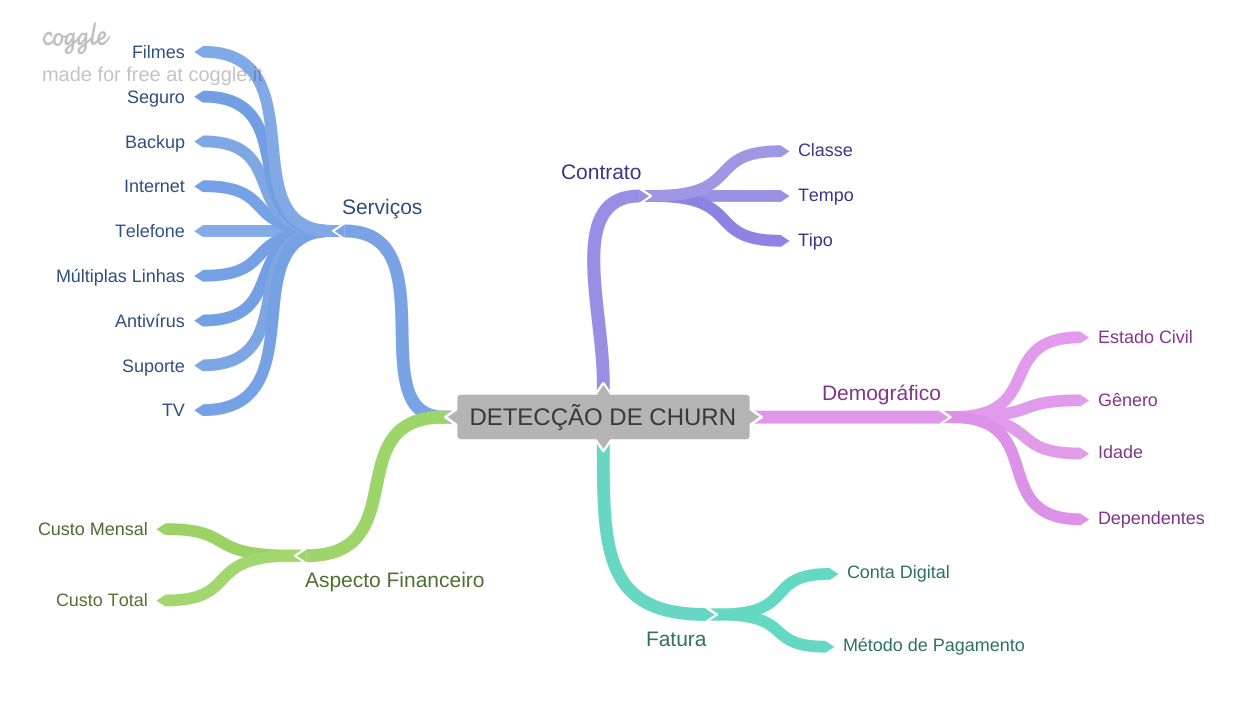

In [151]:
Image('img/Mindmap.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Demográficas

**1.** O gênero influêcia a probabilidade de churn?

**2.** Idosos são menos propensos a entrar em churn?

**3.** Clientes casados são menos propensos a entrar em churn?

**4.** Clientes com dependentes são menos propensos a entrar em churn?

### 2.2.2. Hipóteses Contrato

**1.** Contratos mais longos são menos propensos a entrar em churn?

**2.** Contratos mensais são mais propensos a entrar em churn?

**3.** Contratos que estão no primeiro ano são mais propensos a entrar em churn?

### 2.2.3. Hipóteses Serviços

**1.** Clientes com múltiplas linhas são menos propensos a entrar em churn?

**2.** Clientes com telefone são menos propensos a entrar em churn?

**3.** Clientes com internet de fibra são menos propensos a entrar em churn?

**4.** Clientes com serviços de TV ou filmes são menos propensos a entrar em churn?

**5.** Clientes com serviços adicionais são menos propensos a entrar em churn?

### 2.2.4. Hipóteses Pagamento

**1.** Clientes com conta digital são menos propensos a entrar em churn?

**2.** O método de pagamento influencia a probabilidade de churn?

### 2.2.5. Hipóteses Financeiro

**1.** Custo mensais elevados aumentam a propensão a entrar em churn?

**2.** Custos totais elevados diminuem a propensão a entrar em churn?

## 2.3. Lista Final de Hipóteses

**1.** O gênero influêcia a probabilidade de churn?

**2.** Idosos são menos propensos a entrar em churn?

**3.** Clientes casados são menos propensos a entrar em churn?

**4.** Clientes com dependentes são menos propensos a entrar em churn?

**5.** Contratos mais longos são menos propensos a entrar em churn?

**6.** Contratos mensais são mais propensos a entrar em churn?

**7.** Contratos que estão no primeiro ano são mais propensos a entrar em churn?

**8.** Clientes com múltiplas linhas são menos propensos a entrar em churn?

**9.** Clientes com telefone são menos propensos a entrar em churn?

**10.** Clientes com internet de fibra são menos propensos a entrar em churn?

**11.** Clientes com serviços de TV ou Filmes são menos propensos a entrar em churn?

**12.** Clientes com serviços adicionais são menos propensos a entrar em churn?

**13.** Clientes com conta digital são menos propensos a entrar em churn?

**14.** O método de pagamento influencia a probabilidade de churn?

**15.** Custo mensais elevados aumentam a propensão a entrar em churn?

**16** Custos totais elevados diminuem a propensão a entrar em churn?

O objetivo do passo 02 foi entender melhor as variáveis do dataset e levantar em hipóteses de como elas se relacionam com a variável resposta.

# 3.0. PASSO 03 - ANÁLISE EXPLORATÓRIA DE DADOS

In [152]:
df3 = df2.copy()

In [153]:
df3.head()

,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,Churn,ClasseTempoContrato
0,Feminino,False,False,False,1,True,False,Fibra,False,False,False,False,False,True,Mensal,True,Conta Eletronica,79.70,79.70,True,Classe_00_12
1,Feminino,False,True,True,7,False,Sem Telefone,DSL,False,False,False,False,False,False,Mensal,True,Conta Eletronica,24.70,149.05,False,Classe_00_12
2,Masculino,False,False,False,27,True,False,Sem Internet,False,False,False,False,False,False,Mensal,True,Credito Automatico,19.40,460.25,False,Classe_24_48
3,Feminino,False,True,False,56,True,True,Fibra,False,False,True,True,True,True,Bienal,False,Debito Automatico,103.20,5744.35,False,Classe_48_60
4,Feminino,False,True,False,19,True,True,Fibra,False,False,True,False,False,True,Mensal,False,Conta Papel,89.65,1761.05,True,Classe_12_24


## 3.1. Análise Univariada

### 3.1.1. Variável Resposta

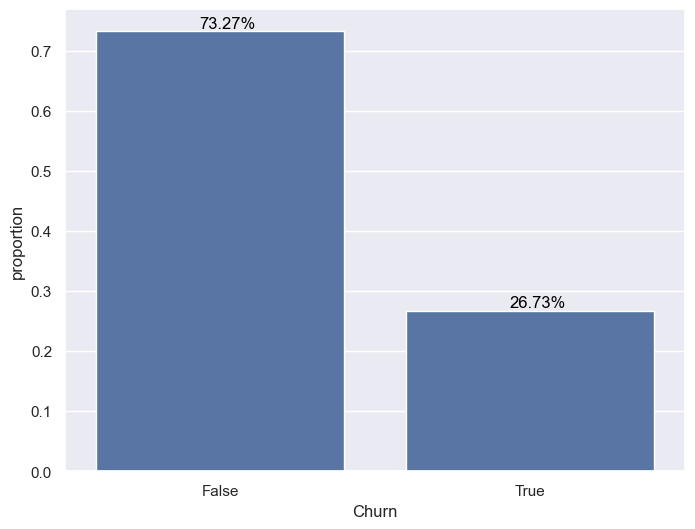

In [154]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=df3['Churn'].value_counts(normalize=True).reset_index(), x="Churn", y="proportion", ax=ax)
set_annotate(fig=fig, porcentages=True)

plt.show()

1/4 dos clientes acabam entrando em churn, o que é uma taxa alta. Apresenta um problema de dados desbalanceados.

### 3.1.2. Variáveis Numéricas

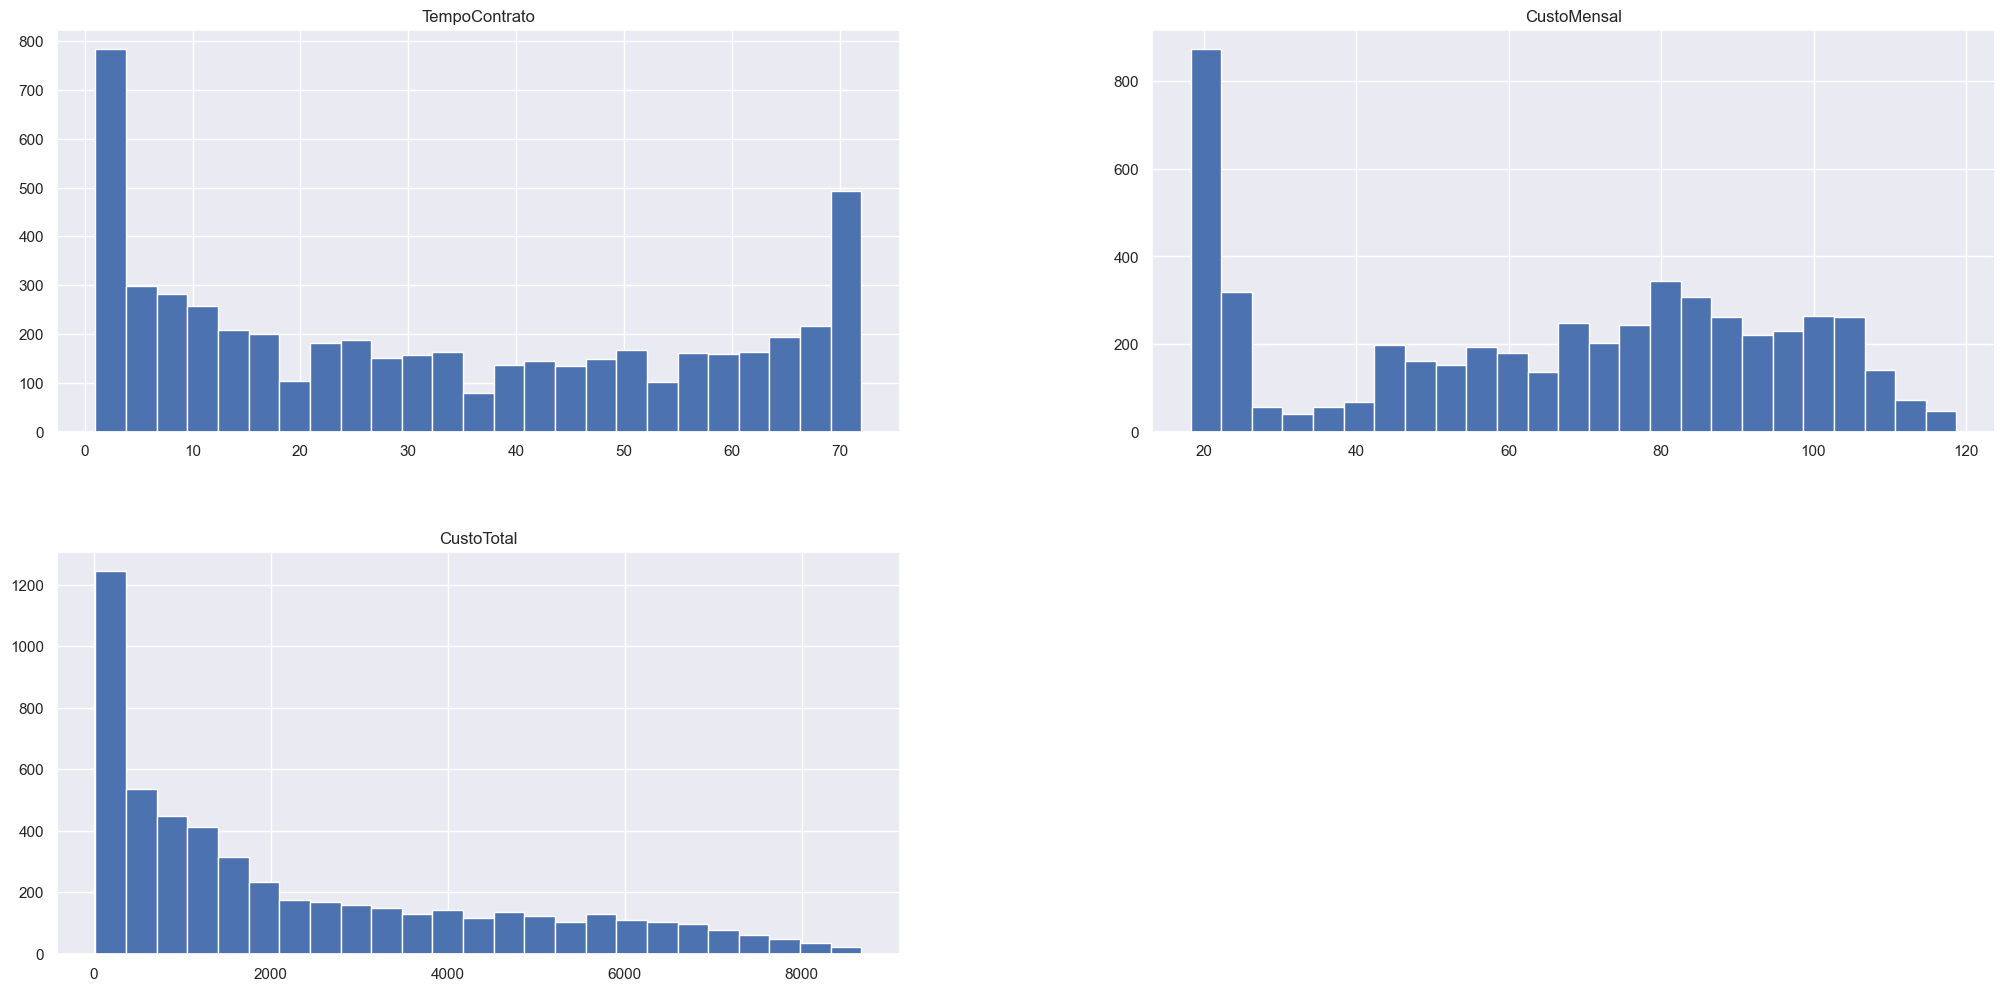

In [155]:
num_attributes.hist (bins = 25)
plt.show()

- Tempo de Contrato e Custo Mensal criam uma distribuição bimodal com picos presentes em 0 - 70 e 20 - 80 respectivamente.
- Custo Total exibe uma distribuição com um skewness positivo.

### 3.1.3. Variáveis Categóricas

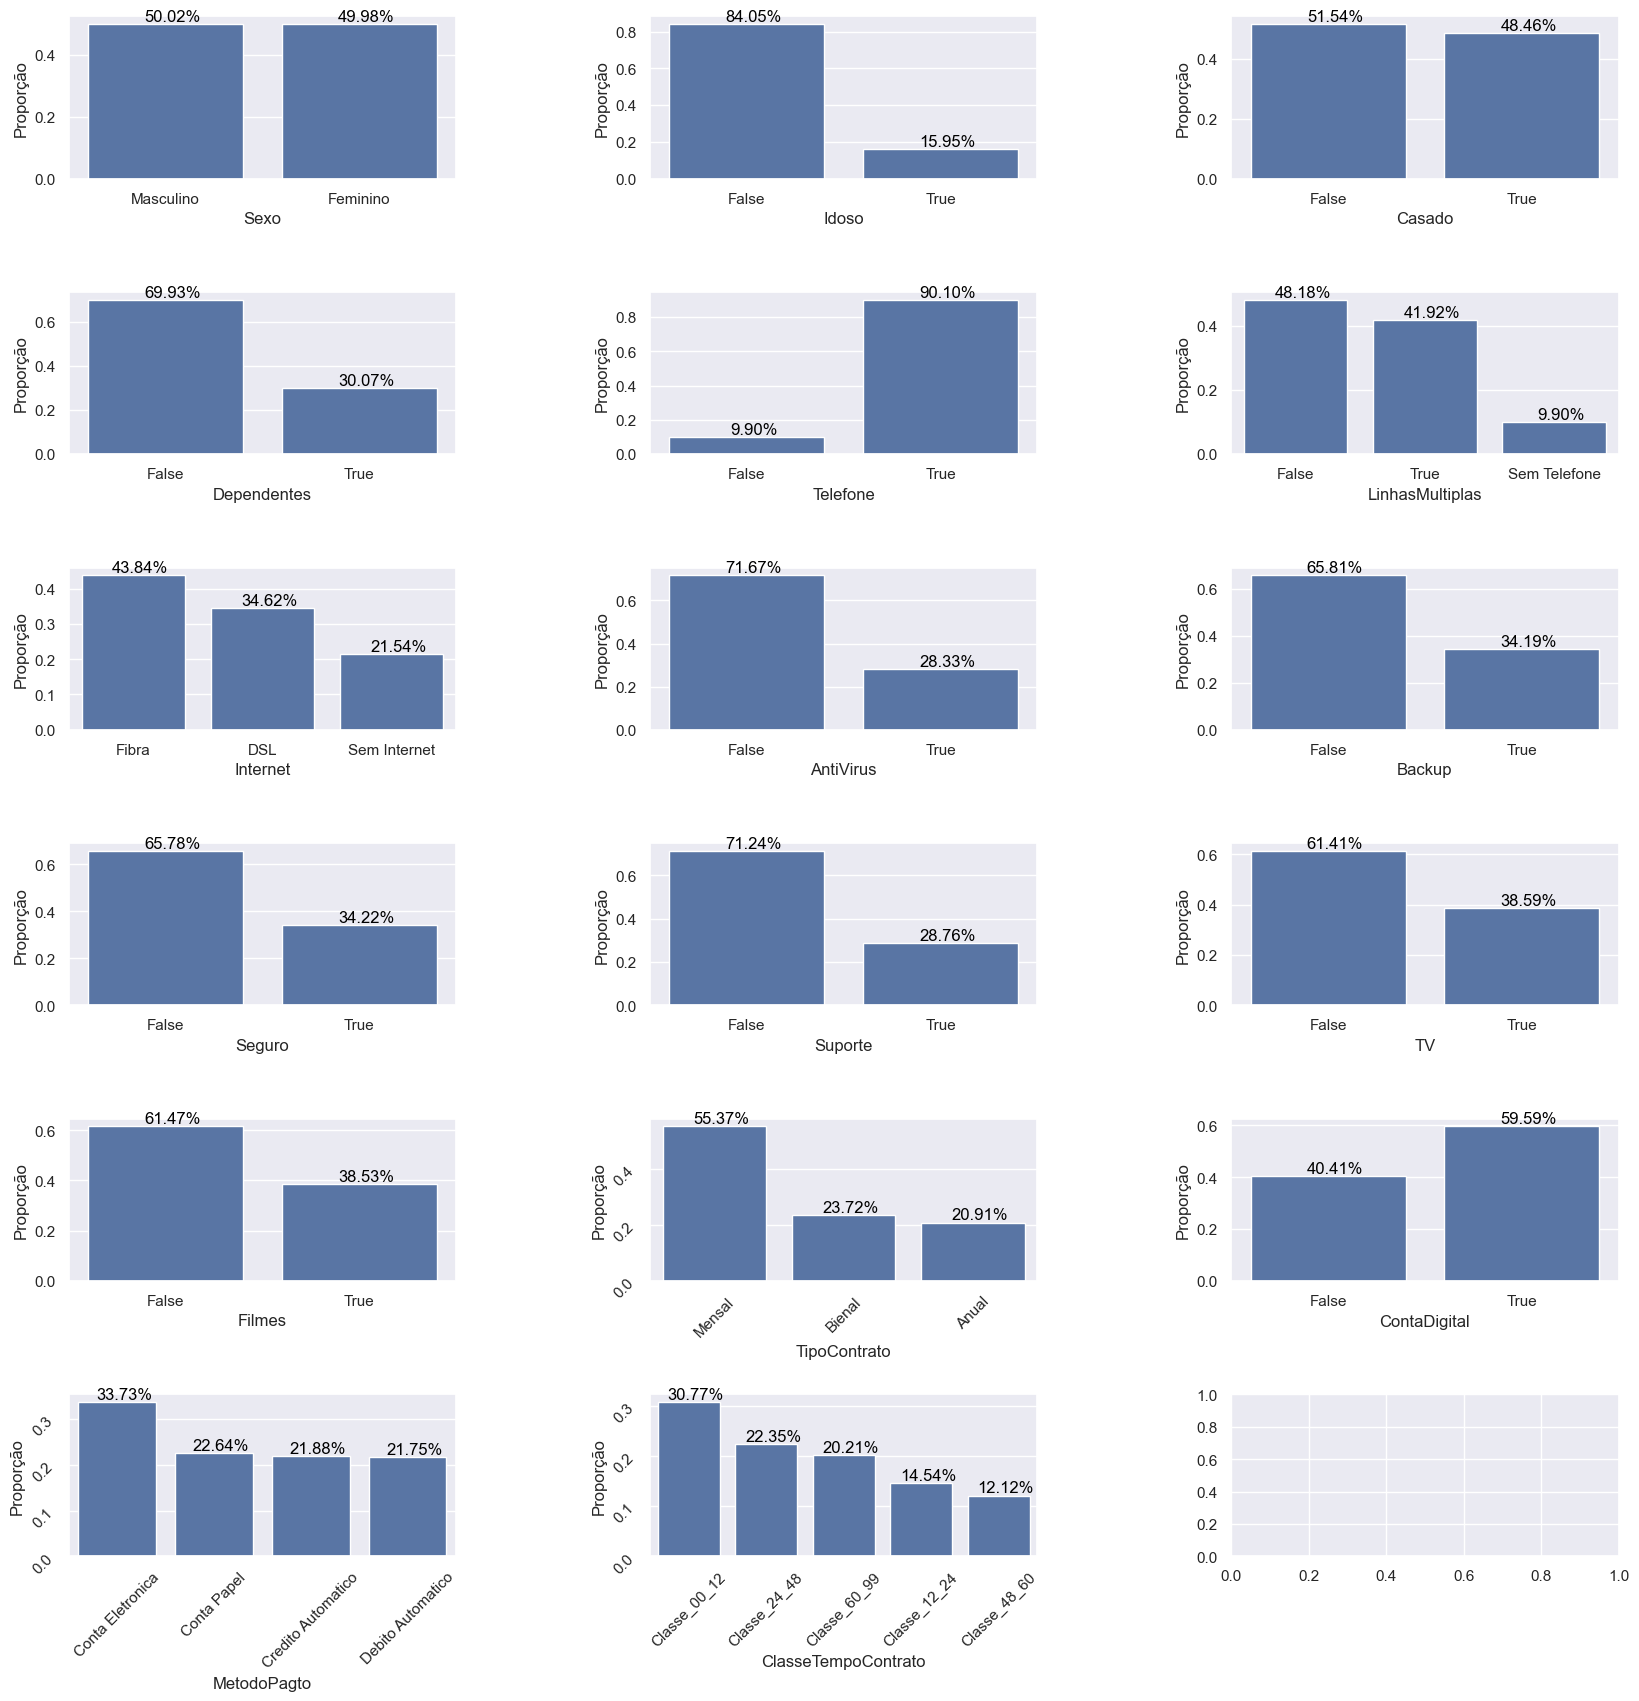

In [156]:
cols = ['Sexo', 'Idoso', 'Casado', 'Dependentes', 'Telefone', 'LinhasMultiplas',
       'Internet', 'AntiVirus', 'Backup', 'Seguro', 'Suporte', 'TV', 'Filmes',
       'TipoContrato', 'ContaDigital', 'MetodoPagto', 'ClasseTempoContrato']

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,20))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.7)
ax = ax.flatten()

for i, col in enumerate(cols):
    sns.barplot(data=df3[col].value_counts(normalize=True).reset_index(), x=col, y='proportion', ax=ax[i])
    ax[i].set_xlabel(''.join([col[0].upper(), col[1:]]))
    ax[i].set_ylabel('Proporção')

    if col in ['MetodoPagto', 'TipoContrato', 'ClasseTempoContrato']:
        ax[i].tick_params(rotation=45)

set_annotate(fig=fig, porcentages=True)
plt.show()

## 3.2. Análise Bivariada

### H1. O gênero influêcia a probabilidade de churn?

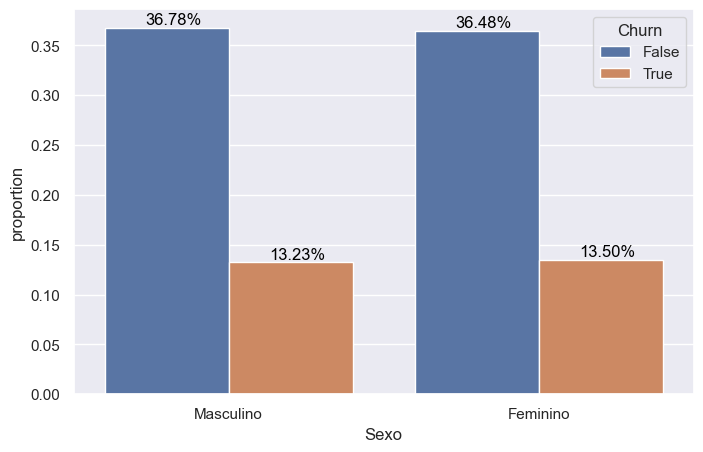

In [157]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['Sexo', 'Churn']].value_counts(normalize=True).reset_index(), x='Sexo', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. Não há relação entre gênero e churn.

### H2.Idosos são menos propensos a entrar em churn?

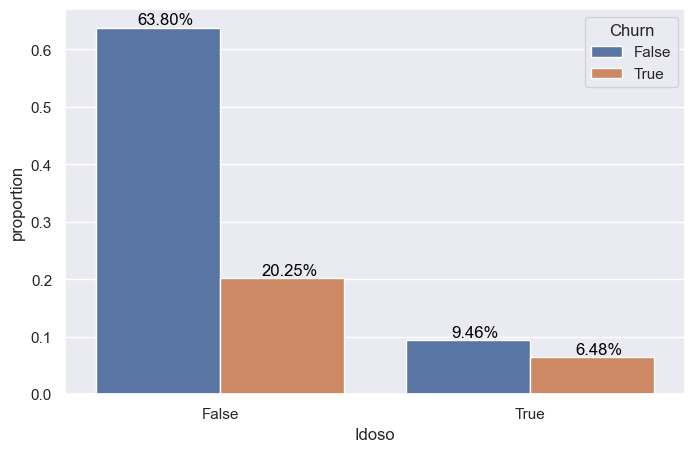

In [158]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['Idoso', 'Churn']].value_counts(normalize=True).reset_index(), x='Idoso', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. A proporção de churns é 2.15x maior em idosos. Possíveis causas observadas seriam o falecimento dos clientes ou uma incompatibilidade com os serviços oferecidos.

### H3. Clientes casados são menos propensos a entrar em churn?

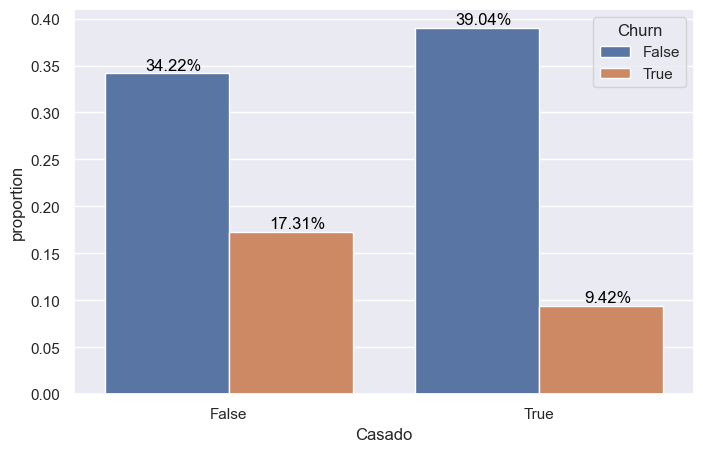

In [159]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['Casado', 'Churn']].value_counts(normalize=True).reset_index(), x='Casado', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Verdadeiro. Clientes solteiros possuem uma proporção de churn 2.09x maior do que clientes casados.

### H4. Clientes com dependentes são menos propensos a entrar em churn?

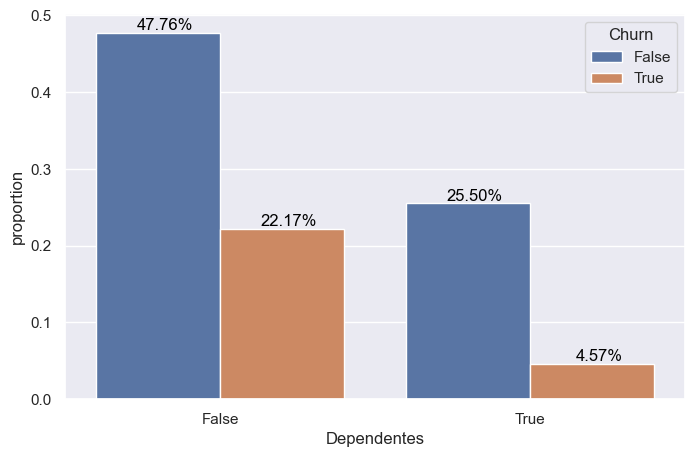

In [160]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['Dependentes', 'Churn']].value_counts(normalize=True).reset_index(), x='Dependentes', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Verdadeiro. Clientes sem dependentes possuem uma proporção de churns 2.59x maior.

### H5. Contratos mais longos são menos propensos a entrar em churn?

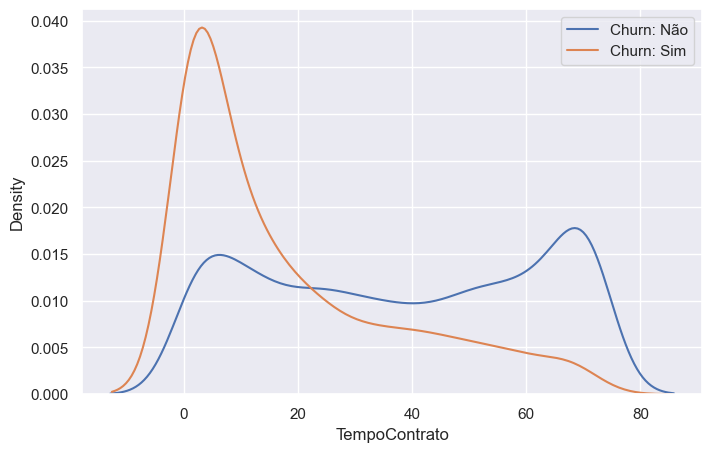

In [161]:
fig, ax = plt.subplots(figsize=(8,5))
ax0 = sns.kdeplot(df3[df3['Churn'] == False]['TempoContrato'], label= 'Churn: Não')
ax1 = sns.kdeplot(df3[df3['Churn'] == True]['TempoContrato'], label= 'Churn: Sim')
plt.legend()
plt.show()

- Verdadeiro. É possível observar uma diminuição drástica no número de churns nos clientes que permanecem com contrato vigente por mais de 1 ano.
- Uma solução para diminuir o número de churns seria aumentar o incentivo aos clientes para permanecerem mais de um ano.

### H6. Contratos mensais são mais propensos a entrar em churn?

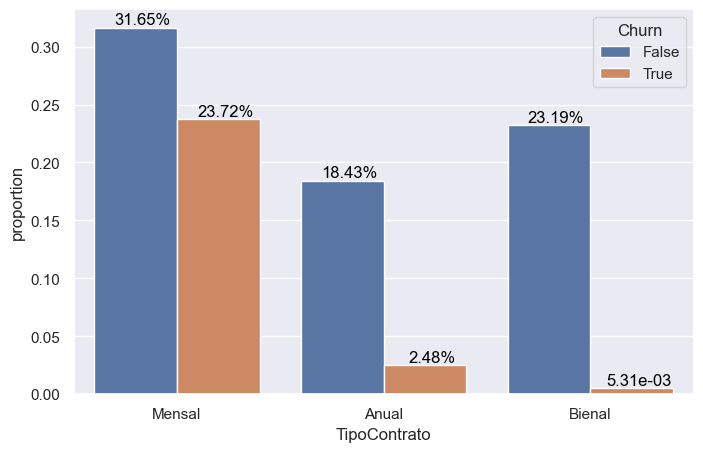

In [162]:
fig, ax = plt.subplots(figsize=(8,5))
order = ['Mensal', 'Anual', 'Bienal']
sns.barplot(data=df3[['TipoContrato', 'Churn']].value_counts(normalize=True).reset_index(), x='TipoContrato', y="proportion", hue="Churn", order=order)
set_annotate(fig=fig, porcentages=True)
plt.show()

- Verdadeiro. Clientes com contratos mensais possuem uma proporção de churns 4.32x maior que clientes com contratos anuais.
- Uma boa medida seria incentivar clientes à aderirem contratos anuais ou bienais.

### H7. Contratos que estão no primeiro ano são mais propensos a entrar em churn?

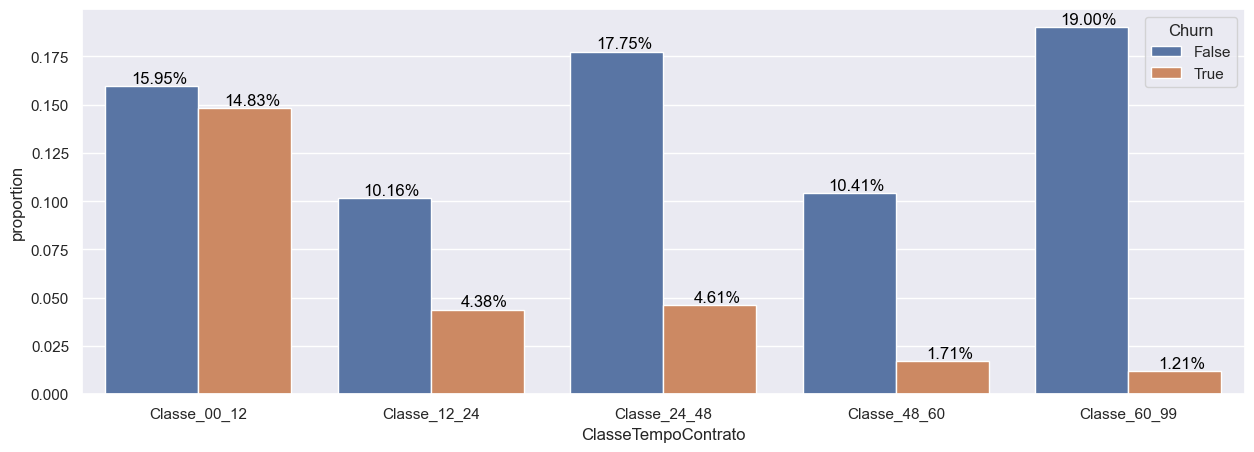

In [163]:
fig, ax = plt.subplots(figsize=(15,5))
order = ['Classe_00_12', 'Classe_12_24', 'Classe_24_48', 'Classe_48_60', 'Classe_60_99']
sns.barplot(data=df3[['ClasseTempoContrato', 'Churn']].value_counts(normalize=True).reset_index(), x='ClasseTempoContrato', y="proportion", hue="Churn", order=order)
set_annotate(fig=fig, porcentages=True)
plt.show()

- Verdadeiro. Clientes no primeiro ano possuem uma proporção de churns 2.17x maior que clientes no segundo ano.
- Uma boa medida, combinada com o insight anterior, seria incentivar clientes a permanecerem mais de um ano em contrato.

### H8. Clientes com múltiplas linhas são menos propensos a entrar em churn?

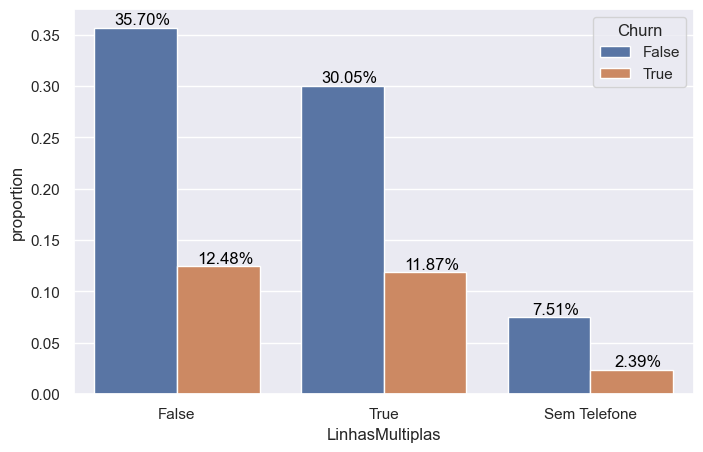

In [164]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['LinhasMultiplas', 'Churn']].value_counts(normalize=True).reset_index(), x='LinhasMultiplas', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. Não há uma variação significante na proporção de churns entre clientes com ou sem múltiplas linhas telefônicas.

### H9. Clientes com telefone são menos propensos a entrar em churn?

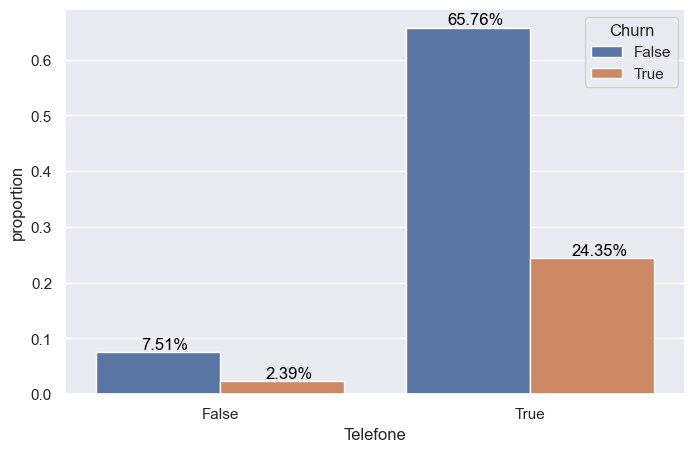

In [165]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['Telefone', 'Churn']].value_counts(normalize=True).reset_index(), x='Telefone', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. Não há uma variação significante na proporção de churns entre clientes com ou sem plano de telefonia.

### H10. Clientes com internet de fibra são menos propensos a entrar em churn?

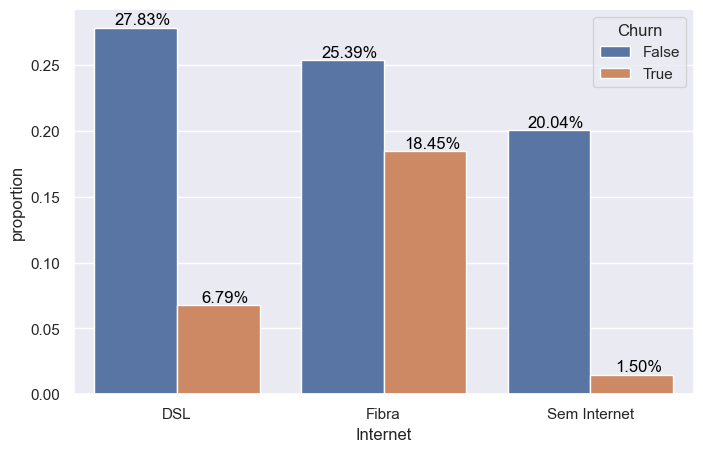

In [166]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['Internet', 'Churn']].value_counts(normalize=True).reset_index(), x='Internet', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. Clientes com Fibra possuem uma proporção de churns 2.97x maior que clientes com DSL.
- É possível que clientes estejam insatisfeitos com a qualidade ou o custo/benefício da internet de fibra óptica.

### H11. Clientes com serviços de TV ou Filmes são menos propensos a entrar em churn?

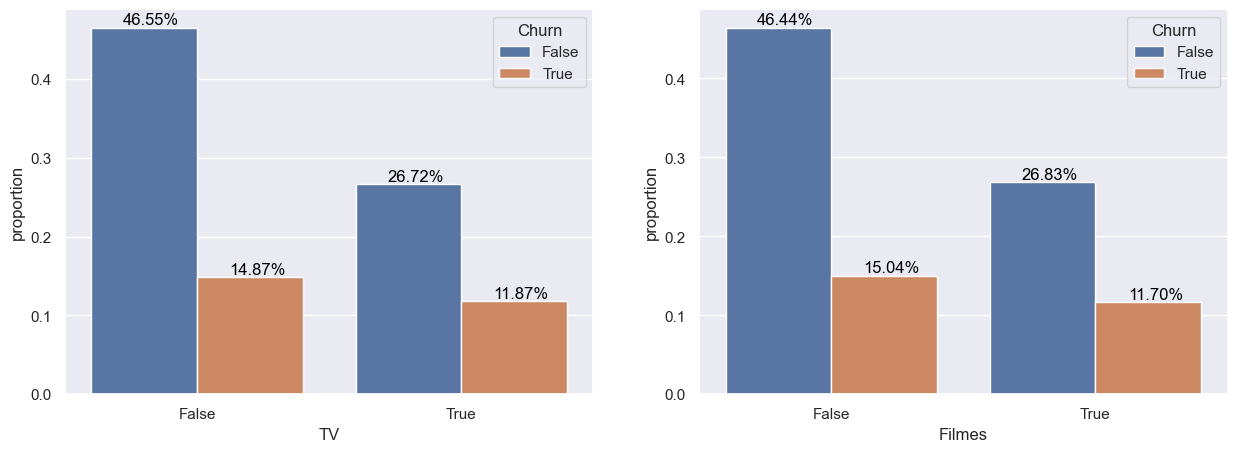

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data=df3[['TV', 'Churn']].value_counts(normalize=True).reset_index(), x='TV', y="proportion", hue="Churn", ax=ax[0])
sns.barplot(data=df3[['Filmes', 'Churn']].value_counts(normalize=True).reset_index(), x='Filmes', y="proportion", hue="Churn", ax=ax[1])
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. Clientes com serviços de TV ou Filmes possuem uma proporção de churns 1.39x maior que clientes sem algum desses serviços.

### H12. Clientes com serviços adicionais são menos propensos a entrar em churn?

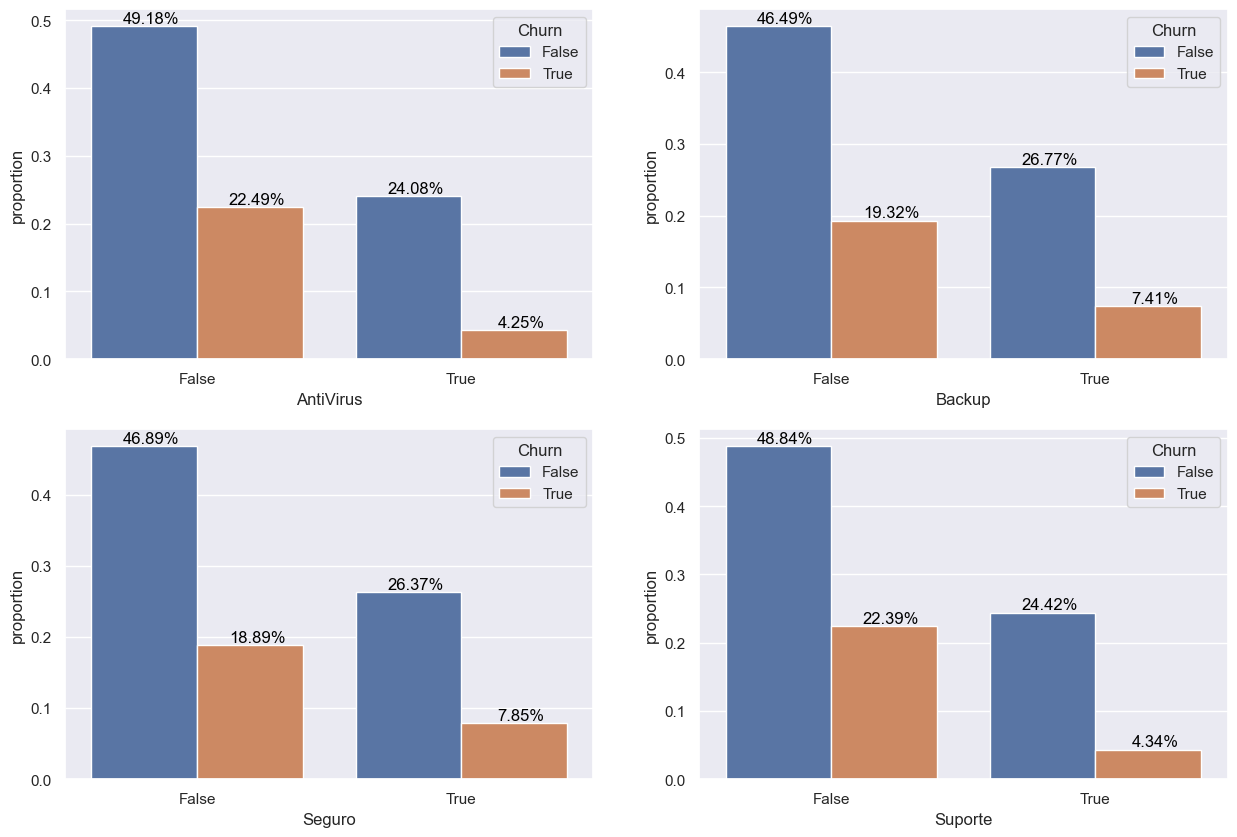

In [168]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.barplot(data=df3[['AntiVirus', 'Churn']].value_counts(normalize=True).reset_index(), x='AntiVirus', y="proportion", hue="Churn", ax=ax[0][0])
sns.barplot(data=df3[['Backup', 'Churn']].value_counts(normalize=True).reset_index(), x='Backup', y="proportion", hue="Churn", ax=ax[0][1])
sns.barplot(data=df3[['Seguro', 'Churn']].value_counts(normalize=True).reset_index(), x='Seguro', y="proportion", hue="Churn", ax=ax[1][0])
sns.barplot(data=df3[['Suporte', 'Churn']].value_counts(normalize=True).reset_index(), x='Suporte', y="proportion", hue="Churn", ax=ax[1][1])
set_annotate(fig=fig, porcentages=True)
plt.show()

- Verdadeiro. Clientes com serviços adicionais possuem uma proporção de churns menor que clientes sem serviços adicionais.

### H13. Clientes com conta digital são menos propensos a entrar em churn?

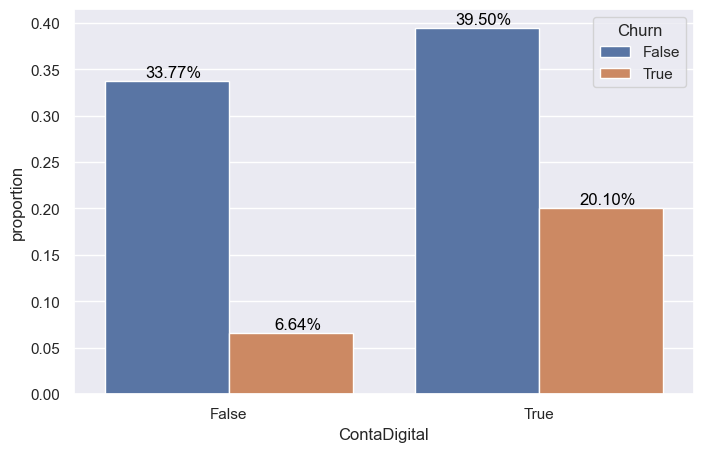

In [169]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df3[['ContaDigital', 'Churn']].value_counts(normalize=True).reset_index(), x='ContaDigital', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Falso. Clientes com contas digitais possuem uma proporção de churns 2.59x maior que clientes sem contas digitais.

### H14. O método de pagamento influencia a probabilidade de churn?

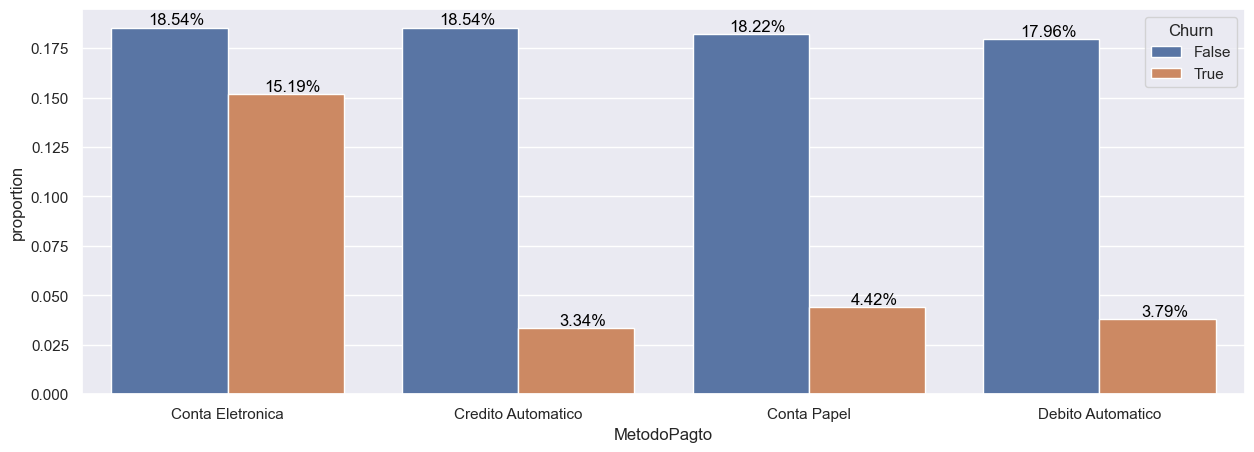

In [170]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=df3[['MetodoPagto', 'Churn']].value_counts(normalize=True).reset_index(), x='MetodoPagto', y="proportion", hue="Churn")
set_annotate(fig=fig, porcentages=True)
plt.show()

- Verdadeiro. Clientes com Conta Eletrônica possuem uma proporção de churns aproximadamente 4.5x maior que com outros métodos de pagamento.

### H15. Custo mensais elevados aumentam a propensão a entrar em churn?

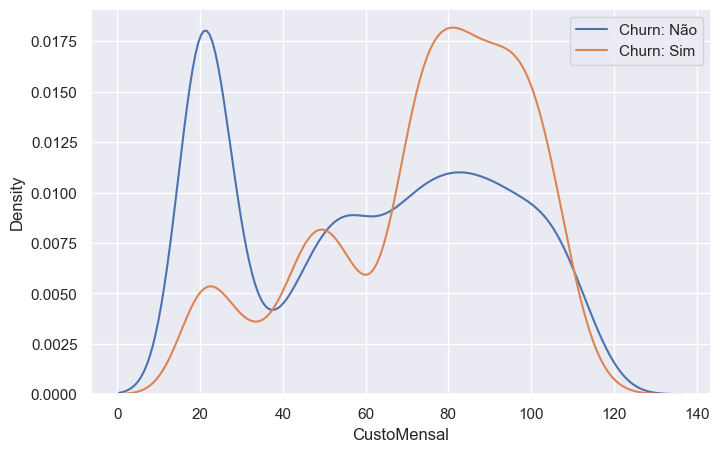

In [171]:
fig, ax = plt.subplots(figsize=(8,5))
ax0 = sns.kdeplot(df3[df3['Churn'] == False]['CustoMensal'], label= 'Churn: Não')
ax1 = sns.kdeplot(df3[df3['Churn'] == True]['CustoMensal'], label= 'Churn: Sim')
plt.legend()
plt.show()

- Verdadeiro. A taxa de churns tende a aumentar significativamente a partir do valor de 60$.

### H16 Custos totais elevados diminuem a propensão a entrar em churn?

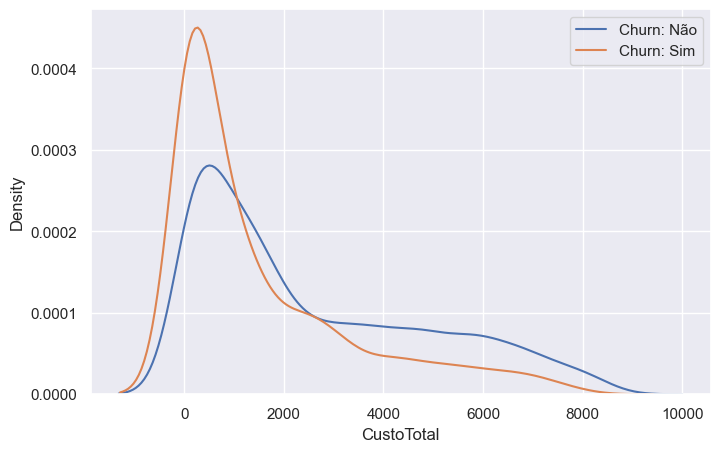

In [172]:
fig, ax = plt.subplots(figsize=(8,5))
ax0 = sns.kdeplot(df3[df3['Churn'] == False]['CustoTotal'], label= 'Churn: Não')
ax1 = sns.kdeplot(df3[df3['Churn'] == True]['CustoTotal'], label= 'Churn: Sim')
plt.legend()
plt.show()

- Verdadeiro. Como observado em análises anteriores, clientes tendem a entrar em churn logo no primeiro ano de contrato, o que ocasiona um baixo custo total.

## 3.3. Análise Multivariada

### 3.3.1. Correlação Atributos Numéricos

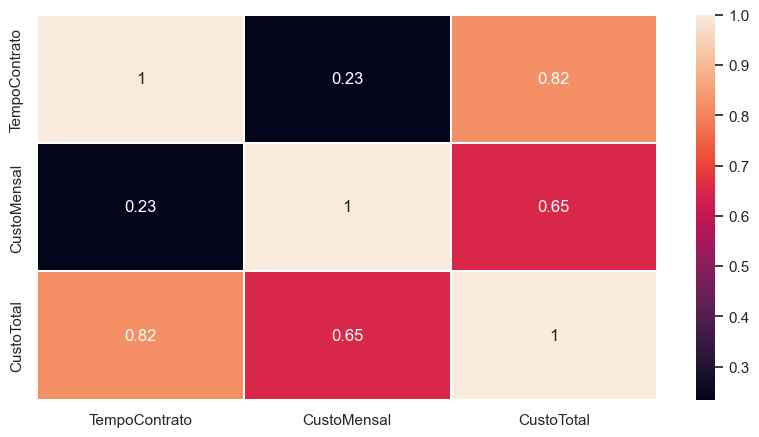

In [173]:
plt.figure(figsize=(10, 5))
corr_num = num_attributes.corr (method = 'pearson')
sns.heatmap (corr_num, xticklabels=corr_num.columns, yticklabels=corr_num.columns, linewidths=.2, annot = True);
plt.show()

### 3.3.2. Correlação Atributos Categóricos 

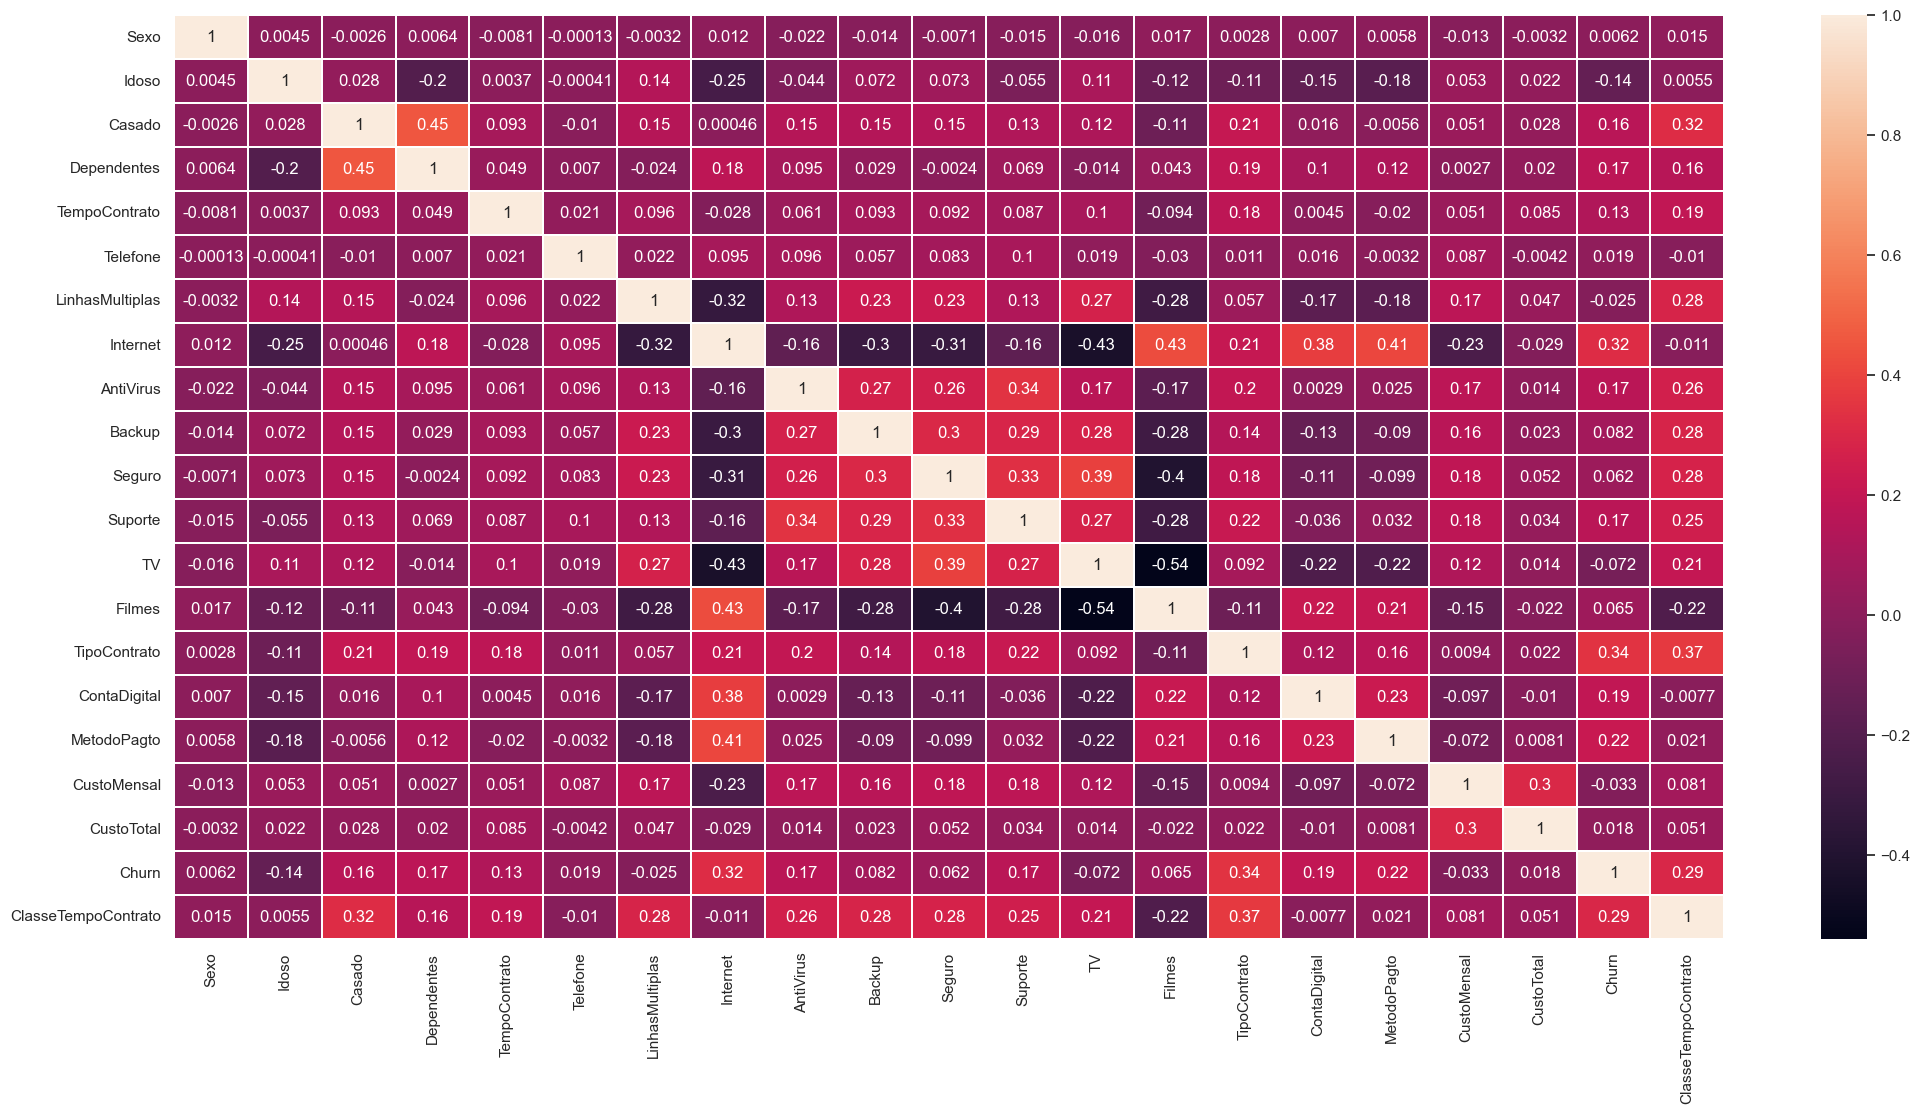

In [174]:
corr = df3.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, annot=True)
plt.show()

## 3.4. Feature Importance

Para obter as informações de features importantes, usaremos o classificador Random Forest, um modelo baseado em árvores de decisão Usei o one-hot encoding para codificar as características categóricas. Também testei manualmente alguns hiperparâmetros para obter um modelo melhor.

In [175]:
df3_fi = df3.copy()

In [176]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
df3_fi = pd.get_dummies(df3_fi)
# Drop redundant columns (for features with two unique values)
drop = ['Churn', 'Sexo_Feminino']
x, y = df3_fi.drop(drop,axis=1), df3_fi['Churn']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

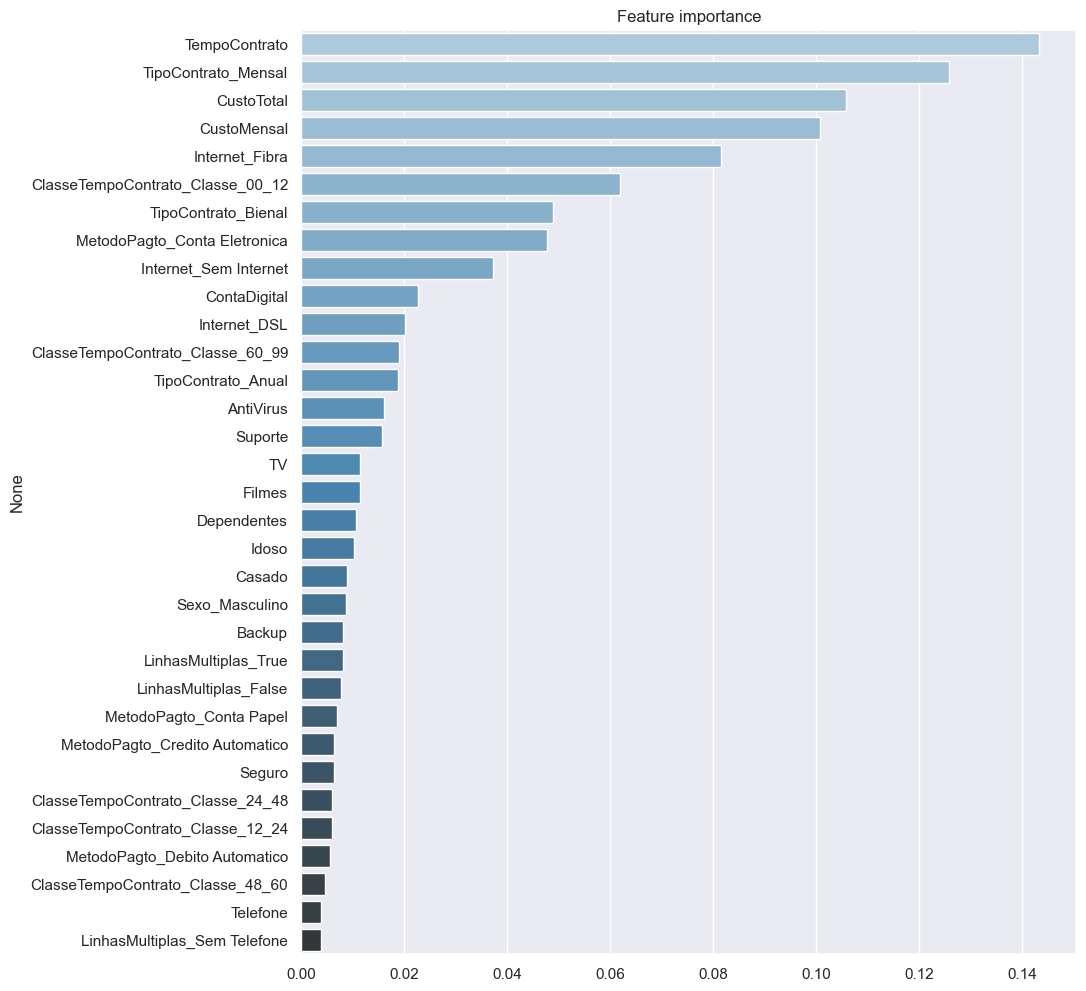

In [177]:
plt.show()

Foram observados pontos interessantes através da Análise Exploratória de Dados. As 6 principais variáveis que influenciam na alta taxa de churns são:
- Tempo de contrato;
- Tipo de contrato ser mensal;
- Custo total;
- Custo mensal;
- Serviço de internet de fibra óptica;
- Contrato em vigência no primeiro ano;

# 4.0. PASSO 04 - PREPROCESSAMENTO DOS DADOS

In [178]:
df4 = df3.copy()

## 4.1. Separação do Dataset

In [179]:
X = df4.drop(['Churn', 'ClasseTempoContrato'], axis=1)
y = df4['Churn']

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Separação do dataset em treino e validação, numa proporção de 20% para teste.

## 4.2. Transformação de Variáveis

In [181]:
# Variáveis Categóricas
cat = ['LinhasMultiplas', 'Internet', 'TipoContrato', 'MetodoPagto']
# Categóricas Binárias
cat_bin = ['Sexo', 'Idoso', 'Casado', 'Dependentes', 'Telefone', 'AntiVirus', 'Backup', 'Seguro',
           'Suporte', 'TV', 'Filmes', 'ContaDigital']
# Numéricas
num = ['TempoContrato', 'CustoMensal', 'CustoTotal']

Diferenciação entre variáveis categóricas, variáveis binárias e numéricas.

### 4.2.1. Transformações para Modelos Lineares

In [182]:
cat_transf_lin = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('target', WOEEncoder())
])

cat_bin_transf_lin = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary', BinaryEncoder())
])

num_transf_lin = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

pre_process_lin = ColumnTransformer(transformers=[
    ('cat', cat_transf_lin, cat),
    ('cat_bin', cat_bin_transf_lin, cat_bin),
    ('num', num_transf_lin, num)
])

Transformações nas variáveis para modelos lineares. Foram usadas:
- Weight of Evidence (WOE);
- Binary Encoder;
- Standart Scaler;

### 4.2.2. Transformações para Modelos de Árvore de Decisão

In [183]:
cat_transf_tree = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', TargetEncoder())
])

cat_bin_transf_tree = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', BinaryEncoder())
])

num_transf_tree = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')
     )
])

pre_process_tree = ColumnTransformer(transformers=[
    ('cat', cat_transf_tree, cat),
    ('cat_bin', cat_bin_transf_tree, cat_bin),
    ('num', num_transf_tree, num)
])

Transformações nas variáveis para modelos baseados em árvores de decisão. Foram usadas:
- Target Encoder;
- Binary Encoder;

# 5.0. PASSO 05 - MODELAGEM DE MACHINE LEARNING

## 5.1. Modelos Lineares

In [184]:
modelos_lineares = [LogisticRegression(random_state=42),  
                    SVC(probability=True, random_state=42), 
                    KNeighborsClassifier()]

In [185]:
score_modelos_lineares = cross_val(X, y, 5, pre_process_lin, modelos_lineares, return_df=True)

In [186]:
score_modelos_lineares.sort_values(by='F1-Score médio', ascending=False)

,Acurácia média,Precisão média,Recall médio,F1-Score médio,ROC-AUC-Score médio,Log Loss
LogisticRegression,0.8 +/- 0.01,0.66 +/- 0.02,0.56 +/- 0.04,0.6 +/- 0.03,0.85 +/- 0.01,7.05 +/- 0.03
SVC,0.8 +/- 0.01,0.68 +/- 0.02,0.49 +/- 0.02,0.57 +/- 0.02,0.81 +/- 0.02,7.16 +/- 0.02
KNeighborsClassifier,0.76 +/- 0.01,0.56 +/- 0.02,0.53 +/- 0.02,0.55 +/- 0.02,0.79 +/- 0.01,8.49 +/- 0.02


## 5.2. Modelos de Árvore de Decisão

In [187]:
modelos_tree = [RandomForestClassifier(random_state=42), 
           DecisionTreeClassifier(random_state=42), 
           XGBClassifier(random_state=42), 
           LGBMClassifier(force_col_wise=True, verbose=0, random_state=42)]

In [188]:
score_modelos_tree = cross_val(X, y, 5, pre_process_tree, modelos_tree, return_df=True)

In [189]:
score_modelos_tree.sort_values(by='F1-Score médio', ascending=False)

,Acurácia média,Precisão média,Recall médio,F1-Score médio,ROC-AUC-Score médio,Log Loss
LGBMClassifier,0.79 +/- 0.01,0.63 +/- 0.02,0.52 +/- 0.03,0.57 +/- 0.02,0.84 +/- 0.01,7.57 +/- 0.02
XGBClassifier,0.78 +/- 0.01,0.61 +/- 0.01,0.52 +/- 0.04,0.56 +/- 0.02,0.82 +/- 0.01,7.86 +/- 0.02
RandomForestClassifier,0.78 +/- 0.01,0.63 +/- 0.02,0.49 +/- 0.04,0.55 +/- 0.02,0.82 +/- 0.01,7.75 +/- 0.02
DecisionTreeClassifier,0.73 +/- 0.01,0.5 +/- 0.02,0.51 +/- 0.02,0.51 +/- 0.02,0.66 +/- 0.01,9.65 +/- 0.02


- Foram testados diferentes tipos de modelos, tanto lineares quanto baseados em árvores de decisão. A partir deles, foi escolhido o com maior Recall Médio, a Regressão Logística.
- Para avaliar os modelos, foi utilizado a técnica de reamostragem Cross Validation. Ela garante uma diminuição na avaliação por overfiting.

O significado das métricas são:
- Acurácia: Proporção de clientes corretamente classificados como "churn" (desistentes) ou "não churn" (retidos) em relação ao total de clientes avaliados.
- Precisão: Proporção de clientes corretamente identificados como "churn" entre todos os clientes que o modelo previu como "churn". Alta precisão significa menos falsos positivos (ou seja, menos clientes que foram identificados como churn, mas na verdade não iriam sair).
- Recall: Proporção de clientes que realmente deram churn e que foram corretamente identificados como churn pelo modelo. Alto recall significa que o modelo conseguiu identificar a maioria dos clientes que realmente dariam churn, reduzindo falsos negativos.
- F1-Score: Combina precisão e recall em uma única métrica. No contexto de churn, um bom F1-Score indica que o modelo está equilibrando bem a identificação correta de churns (precisão) e a captura da maioria dos churns (recall), especialmente útil quando há desequilíbrio entre as classes (muito mais clientes que não dão churn do que os que dão). Essa é a métrica que daremos mais valor para o nosso modelo.
- ROC-AUC-Score: Mede a capacidade do modelo de distinguir entre clientes que vão dar churn e os que não vão em diferentes limiares de decisão. Um valor alto de AUC indica que o modelo é bom em separar os churns dos não churns, independentemente do limiar escolhido.
- Log Loss: Avalia a confiança das previsões do modelo. No contexto de churn, penaliza previsões menos confiantes ou incorretas, como prever com alta confiança que um cliente não dará churn quando na verdade ele dará. Quanto menor o Log Loss, mais confiantes e precisas são as previsões do modelo.cores.

## 5.3. Performance Modelo Escolhido

In [190]:
pipe = Pipeline(steps=[
                ("preprocessor", pre_process_lin),   
                ("classifier", LogisticRegression())
            ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target',
                                                                   WOEEncoder())]),
                                                  ['LinhasMultiplas',
                                                   'Internet', 'TipoContrato',
                                                   'MetodoPagto']),
                                                 ('cat_bin',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Sexo', 'Idoso', 'Casado',
                                                   'Dependentes', 'Telefone',
                                                   'AntiVirus', 'Backup',
                                                   'Seguro', 'Suporte', 'TV',
                                                   'Filmes', 'ContaDigital']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['TempoContrato',
                                                   'CustoMensal',
                                                   'CustoTotal'])])),
                ('classifier', LogisticRegression())])

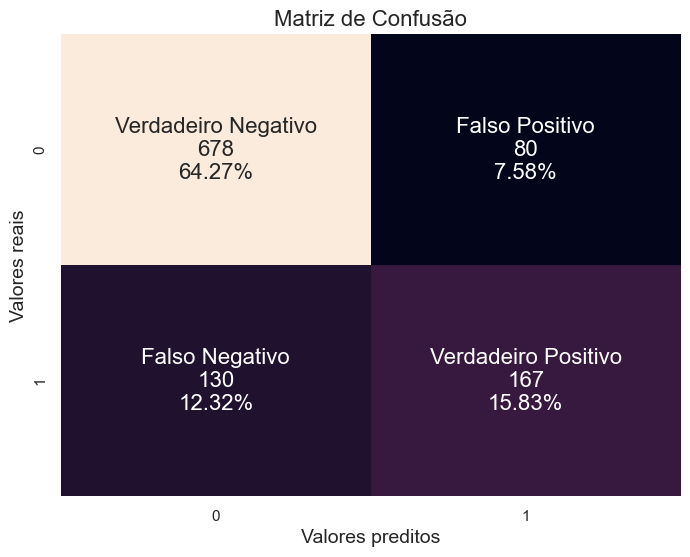

In [191]:
conf_matrix(pipe, X_test, y_test)

In [192]:
y_pred = pipe.predict(X_test)

print(f"Acurracy score: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"LogLoss: {log_loss(y_test, y_pred):.5}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%} \n")

Acurracy score: 80.09%
Precision Score: 67.61%
Recall Score: 56.23%
F1 Score: 61.40%
LogLoss: 7.1746
ROC AUC Score: 72.84% 



Métricas não surpreendentes. O Recall está muito baixo, o que será corrigido no próximo passo.

# 6.0. PASSO 06 - OTIMIZAÇÃO DE HIPERPARÂMETROS

Para encontrar os hiperparâmetros, optei por usar a Bayesian search, método sofitsticado que equilibra automaticamente a exploração de novas áreas do espaço de hiperparâmetros com a exploração de áreas que já demonstraram ser eficientes, melhorando a probabilidade de encontrar hiperparâmetros eficientes com menos avaliações, economizando tempo e recurso.

In [193]:
study = optuna.create_study(direction='maximize', sampler=TPESampler()) 
study.optimize(objective, n_trials=100, n_jobs=3)

[I 2024-09-01 23:14:05,351] A new study created in memory with name: no-name-4a493426-c5be-449b-a065-b8286ba97061
[I 2024-09-01 23:14:05,360] Trial 1 pruned. 
[I 2024-09-01 23:14:05,370] Trial 3 pruned. 
[I 2024-09-01 23:14:05,375] Trial 4 pruned. 
[I 2024-09-01 23:14:13,724] Trial 2 finished with value: 0.0 and parameters: {'penalty': 'elasticnet', 'C': 0.00025163550008412233, 'solver': 'saga', 'l1_ratio': 0.03549851942651816, 'max_iter': 725, 'tol': 0.00023096378288078073, '0': 0.9994176305326827, '1': 1.2581559888430525}. Best is trial 2 with value: 0.0.
[I 2024-09-01 23:14:13,735] Trial 6 pruned. 
[I 2024-09-01 23:14:13,766] Trial 5 finished with value: 0.578023888425143 and parameters: {'penalty': 'l1', 'C': 0.0014191866861804812, 'solver': 'liblinear', 'max_iter': 646, 'tol': 2.550897436710876e-06, '0': 0.6033282913374924, '1': 1.8952617976502921}. Best is trial 5 with value: 0.578023888425143.
[I 2024-09-01 23:14:15,548] Trial 0 finished with value: 0.6293093065264618 and parame

In [194]:
best_params_dict = {k: v for k, v in study.best_params.items() if k not in ['0', '1']} | {'class_weight': {0: study.best_params['0'], 1: study.best_params['1']}}

Foi escolhido a métrica F1-Score para ordenar os parâmetros identificados.

In [195]:
print("Melhores hiperparâmetros:", best_params_dict)

Melhores hiperparâmetros: {'penalty': 'elasticnet', 'C': 0.9549307985447402, 'solver': 'saga', 'l1_ratio': 0.5543879469095716, 'max_iter': 770, 'tol': 7.0566465081994196e-06, 'class_weight': {0: 0.7516556533913564, 1: 1.6267127610857537}}


In [196]:
pipe = Pipeline(steps=[
                ("preprocessor", pre_process_lin),   
                ("classifier", LogisticRegression(**best_params_dict))
            ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target',
                                                                   WOEEncoder())]),
                                                  ['LinhasMultiplas',
                                                   'Internet', 'TipoContrato',
                                                   'MetodoPagto']),
                                                 ('cat_bin',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Sexo',...
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['TempoContrato',
                                                   'CustoMensal',
                                                   'CustoTotal'])])),
                ('classifier',
                 LogisticRegression(C=0.9549307985447402,
                                    class_weight={0: 0.7516556533913564,
                                                  1: 1.6267127610857537},
                                    l1_ratio=0.5543879469095716, max_iter=770,
                                    penalty='elasticnet', solver='saga',
                                    tol=7.0566465081994196e-06))])

# 7.0. PASSO 07 - TRADUÇÃO E INTERPRETAÇÃO DE ERROS

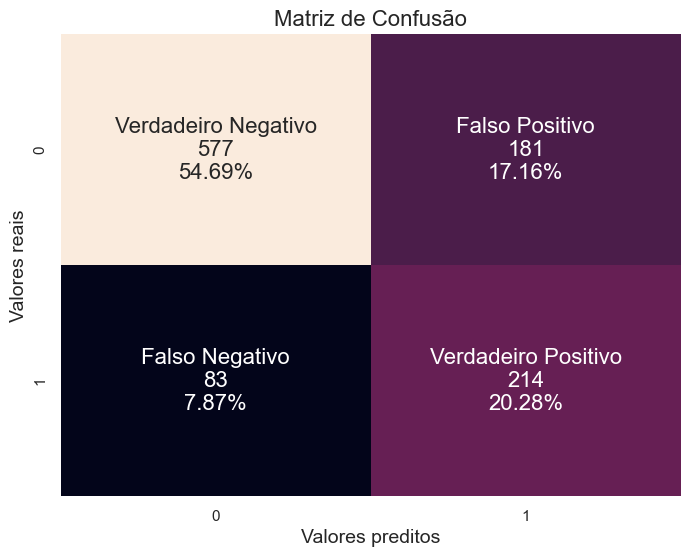

In [197]:
conf_matrix(pipe, X_test, y_test)

In [198]:
y_pred = pipe.predict(X_test)

print(f"Acurracy score: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"LogLoss: {log_loss(y_test, y_pred):.5}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%} \n")

Acurracy score: 74.98%
Precision Score: 54.18%
Recall Score: 72.05%
F1 Score: 61.85%
LogLoss: 9.0195
ROC AUC Score: 74.09% 



Houve um grande aumento no Recall. Nosso modelo é capaz de identificar 74% dos churns.

# 8.0. PASSO 08 - ANÁLISE DE NEGÓCIO

## 1. Quais são os fatores que mais influenciam a saída dos clientes?

In [199]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
df3_fi = pd.get_dummies(df3_fi)
# Drop redundant columns (for features with two unique values)
drop = ['Churn', 'Sexo_Feminino']
x, y = df3_fi.drop(drop,axis=1), df3_fi['Churn']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

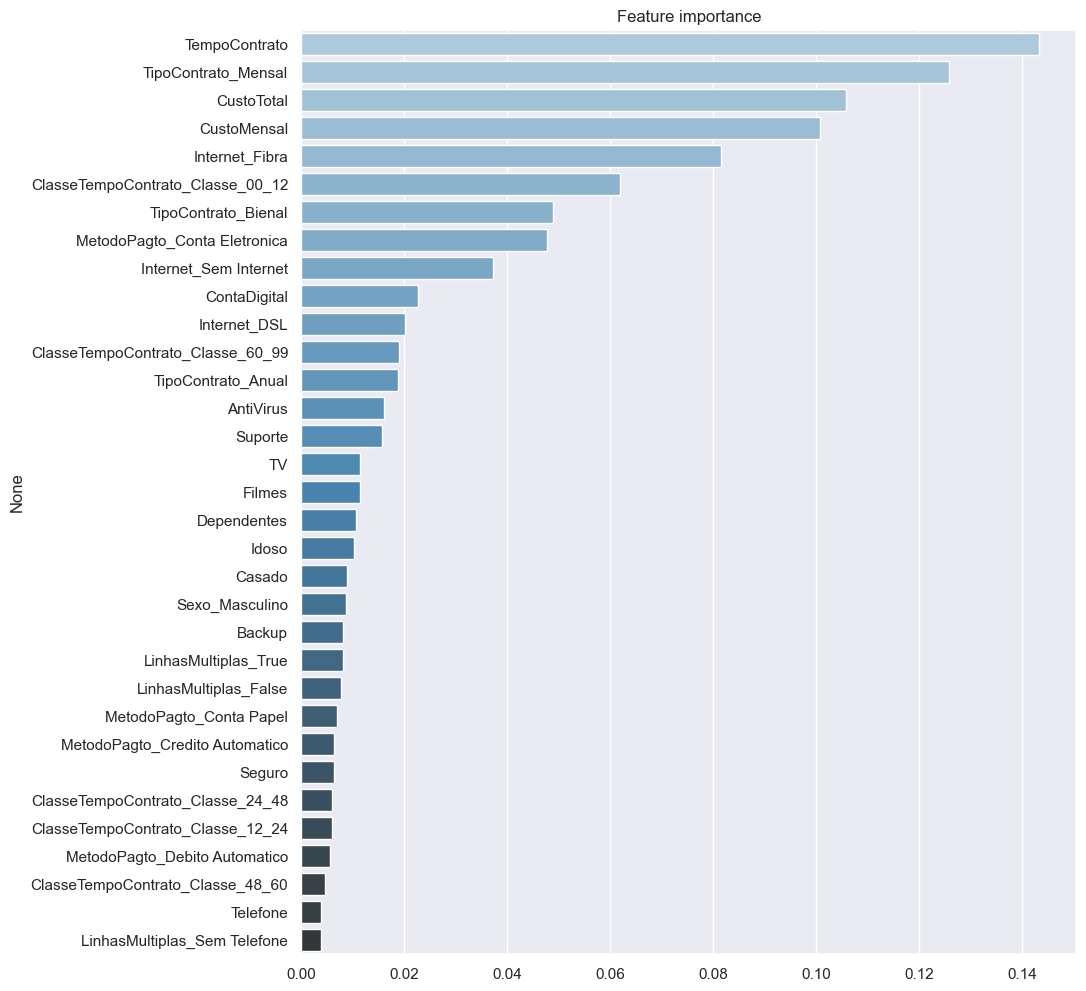

In [200]:
plt.show()

As 6 principais variáveis que influenciam na alta taxa de churns são:
- Tempo de contrato;
- Tipo de contrato ser mensal;
- Custo total;
- Custo mensal;
- Serviço de internet de fibra óptica;
- Contrato em vigência no primeiro ano;

## 2. Quais clientes da base fel_churn_previsão.csv que deveriam ser abordados por marketing em primeiro lugar? 

### 2.1. Loading Dataset

In [201]:
df_pred = pd.read_csv('datasets/fel_churn_previsao_nb_01.csv')

### 2.2. Predição de Churns

In [202]:
df_pred['Churn'] = pipe.predict(df_pred.drop(['ID', 'ClasseTempoContrato'], axis = 1))
df_pred['ChurnProb'] = pipe.predict_proba(df_pred.drop(['ID', 'ClasseTempoContrato'], axis=1))[:, 1]

In [203]:
df_churn = df_pred[df_pred['Churn']]

### 2.3. Seleção e Ordenamento dos Clientes Previstos em Churn

In [204]:
df_churn = df_churn.sort_values(by = 'ChurnProb', ascending = False).reset_index(drop=True)

### 2.4. Exportação dos Resultados

In [205]:
df_churn.to_csv('datasets/resultado_churn.csv', index=False)

In [206]:
df_churn.head()

,ID,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,ClasseTempoContrato,Churn,ChurnProb
0,7024-OHCCK,Feminino,True,False,False,2,True,True,Fibra,False,False,False,False,True,True,Mensal,True,Conta Eletronica,93.85,170.85,Classe_00_12,True,0.91
1,4424-TKOPW,Masculino,True,False,False,2,True,True,Fibra,False,False,False,False,True,True,Mensal,True,Conta Eletronica,93.85,196.75,Classe_00_12,True,0.91
2,5150-ITWWB,Masculino,True,False,False,3,True,True,Fibra,False,False,False,False,True,True,Mensal,True,Conta Eletronica,94.85,335.75,Classe_00_12,True,0.91
3,0295-PPHDO,Masculino,False,False,False,1,True,True,Fibra,False,False,False,False,True,True,Mensal,True,Conta Eletronica,95.45,95.45,Classe_00_12,True,0.91
4,7577-SWIFR,Masculino,False,False,False,1,True,False,Fibra,False,False,False,False,True,True,Mensal,True,Conta Eletronica,89.25,89.25,Classe_00_12,True,0.90


Foi realizado a predição de Churns, filtro para clientes churns no dataframe e ordenamento com base na probabilidade de churn.
Depois, foi exportado um arquivo .csv contendo a lista de clientes que deverão ser abordados com a estratégia de vendas.

## 3. Quanto a empresa economiza (em número de campanhas individuais) ao utilizar o seu resultado?

Após identificar os clientes mais propensos a entrar em churn, pensaremos numa solução para retê-los.
Conforme observado na Análise Exploratória de Dados, há algumas variáveis importantes que podemos usar para atacar o problema da alta taxa de churns.
- Tempo de contrato no primeiro ano;

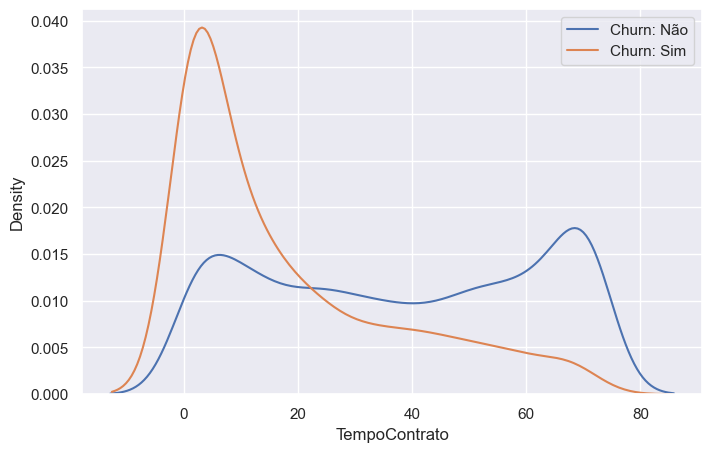

In [207]:
fig, ax = plt.subplots(figsize=(8,5))
ax0 = sns.kdeplot(df3[df3['Churn'] == False]['TempoContrato'], label= 'Churn: Não')
ax1 = sns.kdeplot(df3[df3['Churn'] == True]['TempoContrato'], label= 'Churn: Sim')
plt.legend()
plt.show()

- Custo mensal;

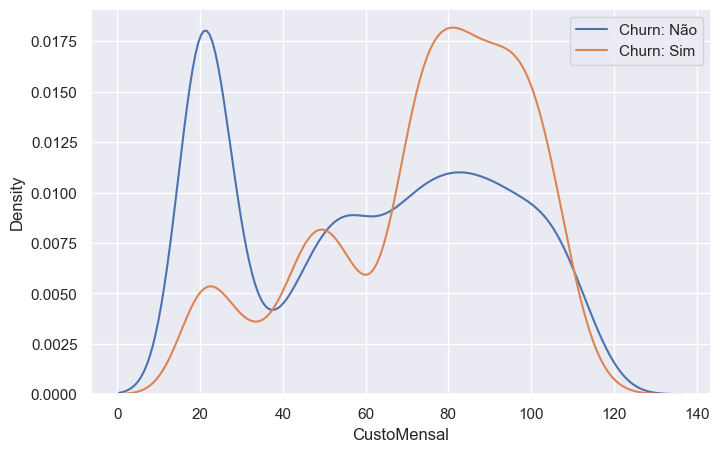

In [208]:
fig, ax = plt.subplots(figsize=(8,5))
ax0 = sns.kdeplot(df3[df3['Churn'] == False]['CustoMensal'], label= 'Churn: Não')
ax1 = sns.kdeplot(df3[df3['Churn'] == True]['CustoMensal'], label= 'Churn: Sim')
plt.legend()
plt.show()

- Tipo de contrato ser mensal;

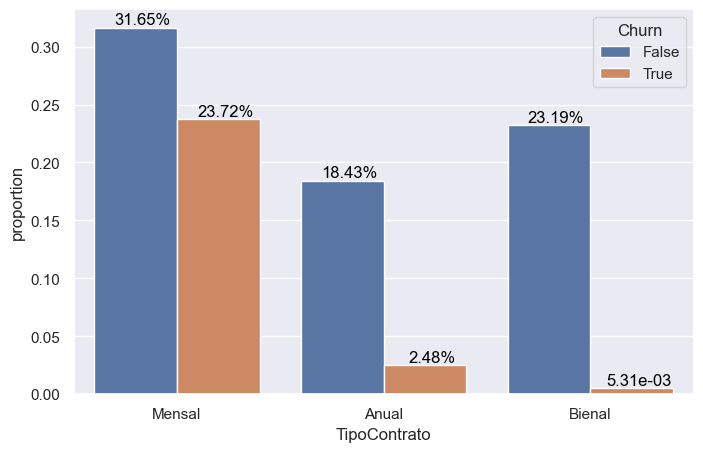

In [209]:
fig, ax = plt.subplots(figsize=(8,5))
order = ['Mensal', 'Anual', 'Bienal']
sns.barplot(data=df3[['TipoContrato', 'Churn']].value_counts(normalize=True).reset_index(), x='TipoContrato', y="proportion", hue="Churn", order=order)
set_annotate(fig=fig, porcentages=True)
plt.show()

Uma boa estratégia inicial para influênciar essas variáveis seria a disponibilização de cupons de desconto de 15% pelo período de 6 meses para todos os clientes previstos em churn que optarem por um tipo de contrato anual. Assim, como observado nos gráficos, os clientes atravessariam o período no qual ocorrem as maiores taxas de churn e mudariam seus contratos de mensais para anuais.

Assim, consideraremos o seguinte cálculo para o ROI:
- Desconto = 15% (0.15)
- Duração do Desconto = 6 meses
- Taxa de Retenção Através do Desconto = 75% (0.75)


Dessa forma, temos que os cálculos envolvidos na análise de negócio se dão por:

Custo do Desconto = (TP+FP) × CustoMensal × Desconto × Durac​ão do Desconto

Receita = TP × CustoMensal × (1−Desconto) × Duracão do Desconto × Taxa de Retencão

ROI = Receita - Custo do Desconto

Churns não identificados = FN × Custo Mensal × Duração do Desconto

O cálculo de receitas e custos para um período de 24 meses é de:

In [210]:
retorno_fin(desconto=0.15, duracao=6, taxa_de_retencao=0.50, threshold=0.5)

Cálculo para um período de 24 meses, com 6 meses de desconto:
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.5 de treshold: 

Recall Score: 0.72%
CUSTO DO DESCONTO: U$ 27269.91
BENEFÍCIO DO DESCONTO: U$ 189746.29
RETORNO LÍQUIDO: U$ 162476.38
PERDA POR CHURNS NÃO IDENTIFICADOS: U$ 135874.80
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



É importante ressaltar que estamos usando uma taxa de retenção de 50%, e que o foco em aumentar a taxa de retenção para essa solução deve estar presente em melhorias futuras.o:

#### Análise do Trade-off entre Lucro Líquido e Perda por Churns Não Classificados
Um threshold alto significa que o modelo é mais conservador na classificação de churns, identificando apenas clientes com alta probabilidade predita de churn. Diminuir o treshold pode ser bom dependendo do cenário. Ao se fazer isso, a margem de erro também aumenta, o que significa um maior custo pela solução, mas maior retenção de clientes. Assim como, um treshold alto diminuiria o custo significativamente mas reteria menos clientes.

##### Aumento de threshold
**Vantagens**:

Maior Precisão: Menos falsos positivos, resultando em menos custos com descontos ou incentivos desnecessários.
Melhoria na Experiência do Cliente: Evita descontos a clientes que não precisam, mantendo a percepção de valor dos serviços

**Desvantagens:**

Perda por Churns Não Classificados: Muitos churns não seriam identificados, resultando em perda de receita.
Perda de participação no mercado: Retenção inadequada pode resultar em perda de participação de mercado e favorecimento da concorrência.
Altos Custos de Aquisição de Clientes: Perder clientes existentes é caro. É mais custoso adquirir novos clientes do que mantê-los.

##### Diminuição de threshold
**Vantagens:**

Maior Recall: Aumento na taxa de churns identificados, ocasionando um aumento de receita.
Manutenção da Participação no Mercado: Melhora a retenção de clientes, ajudando a manter ou aumentar a participação de mercado.
Reforço da Reputação: Intervenções mais frequentes podem melhorar a satisfação do cliente e a reputação da empresa.
Aumento do Valor de Vida do Cliente: Retenção de clientes por períodos mais longos aumenta o valor de vida do cliente, trazendo benefícios financeiros a longo prazo.

**Desvantagens:**

Maior Custo com Descontos/Incentivos: Mais falsos positivos significam mais clientes recebendo descontos ou incentivos desnecessários, aumentando os custos.
Possível Erosão do Valor Percebido: Oferecer descontos a muitos clientes pode levar à percepção de que o serviço/produto não vale o preço total.
Gestão de Recursos: Requer mais recursos para gerenciar e implementar intervenções para um maior número de clientes.

### Abaixo estará o cálculo do ROI para cenários com diferentes thresholds

In [211]:
for i in range(85, 30, -5):
    threshold = i / 100
    retorno_fin(desconto=0.15, duracao=6, taxa_de_retencao=0.5, threshold=threshold)

Cálculo para um período de 24 meses, com 6 meses de desconto:
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.85 de treshold: 

Recall Score: 0.14%
CUSTO DO DESCONTO: U$ 3979.66
BENEFÍCIO DO DESCONTO: U$ 43567.76
RETORNO LÍQUIDO: U$ 39588.09
PERDA POR CHURNS NÃO IDENTIFICADOS: U$ 439622.40
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Cálculo para um período de 24 meses, com 6 meses de desconto:
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.8 de treshold: 

Recall Score: 0.30%
CUSTO DO DESCONTO: U$ 9282.96
BENEFÍCIO DO DESCONTO: U$ 86590.35
RETORNO LÍQUIDO: U$ 77307.39
PERDA POR CHURNS NÃO IDENTIFICADOS: U$ 350224.80
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Cálculo para um período de 24 meses, com 6 meses de desconto:
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Modelo com 0.75 de treshold: 

Recall Score: 0.46%
CUSTO DO DESCONTO: U$ 14168.43
BENEFÍCIO DO DESCONTO: U$ 127425.95
RETORNO LÍQUIDO: U$ 113257.52
PERDA POR CHURNS NÃO IDENTIFICADOS: U$ 265371.60
-=-=-=-=-=-=-=-=-=-=-=-

## 4. Quão boas são suas previsões? Justifique.


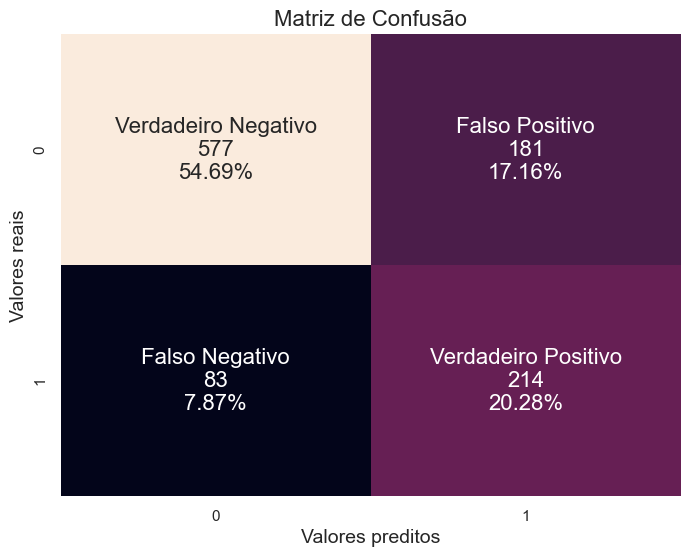

In [212]:
conf_matrix(pipe, X_test, y_test)

In [213]:
y_pred = pipe.predict(X_test)

print(f"Acurracy score: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"LogLoss: {log_loss(y_test, y_pred):.5}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%} \n")

Acurracy score: 74.98%
Precision Score: 54.18%
Recall Score: 72.05%
F1 Score: 61.85%
LogLoss: 9.0195
ROC AUC Score: 74.09% 



- O modelo é capaz de acertar 75% de suas previsões.
- Entre todas as previsões de Churn do modelo, 54% são verdadeiras.
- Entre todos os churns, o modelo foi capaz de identificar 74%
- F1-Score de 62,50%.

## 5. Além das perguntas acima, quais outros insights você conseguiu extrair dessa base de dados, que são importantes de serem apresentados e relevante para a área de negocio?

### Pontos para verificar:

- É importante ter como objetivo manter o máximo possível de clientes por pelo menos 1 ano;
- É importante incentivar contratos anuais;
- Há um indicativo de problemas no serviço de fibra óptica;
- Um plano de retenção de clientes através de descontos de fidelidade podem ser interessantes, visto que a taxa de churn diminui conforme o tempo de contrato;

### Melhorias futuras:

- Analisar programas de descontos passados;
- Ter informações sobre feedbacks dos clientes com relação aos serviços;
- Quantas vezes cada cliente ligou pedindo suporte ou fazendo reclamações?;
- Versionar o modelo (Git) e colocá-lo em produção com monitoramento contínuo (MLFlow);